# UCI SECOM Semiconductor Defect Detection Analysis

**Objective**: Predict semiconductor manufacturing failures (defects) using sensor data.

**Approach**:
1. Label-free feature engineering (to avoid data leakage)
2. Multiple resampling strategies for class imbalance
3. Multiple models with hyperparameter tuning via CV
4. Primary metric: Recall@Precision>0.2
5. SHAP interpretability for top performers

In [1]:
# Cell 0: Install required libraries (run once)
# Uncomment and run if any packages are missing

!pip install pandas numpy matplotlib seaborn scikit-learn lightgbm xgboost imbalanced-learn shap --quiet

print("All required packages installed!")

All required packages installed!


In [2]:
# Cell 1: Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score, precision_recall_curve, auc,
    confusion_matrix, classification_report,
    average_precision_score, recall_score, precision_score
)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
import shap
import warnings
from itertools import product
from collections import defaultdict

warnings.filterwarnings('ignore')
np.random.seed(42)

print("All imports successful!")

All imports successful!


In [3]:
# Cell 2: Load Data
df = pd.read_csv('uci-secom.csv')

# Rename target column
df = df.rename(columns={'Pass/Fail': 'target'})

# Convert target: -1 (Pass) -> 0, 1 (Fail) -> 1
df['target'] = df['target'].map({-1: 0, 1: 1})

print(f"Dataset shape: {df.shape}")
print(f"\nTarget distribution:")
print(df['target'].value_counts())
print(f"\nDefect rate: {df['target'].mean():.2%}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (1567, 592)

Target distribution:
target
0    1463
1     104
Name: count, dtype: int64

Defect rate: 6.64%

First few rows:


,Time,0,1,2,3,4,5,6,7,8,...,581,582,583,584,585,586,587,588,589,target
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,...,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,0
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,...,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,0
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,...,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,...,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,0
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,...,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,0


In [4]:
# Cell 3: Train-Test Split (80/20 stratified)

# Separate features and target
# Drop 'Time' column if it exists (not a sensor feature)
feature_cols = [col for col in df.columns if col not in ['target', 'Time']]
X = df[feature_cols]
y = df['target']

print(f"Total features: {len(feature_cols)}")

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTrain defect rate: {y_train.mean():.2%}")
print(f"Test defect rate: {y_test.mean():.2%}")

Total features: 590

Train set: 1253 samples
Test set: 314 samples

Train defect rate: 6.62%
Test defect rate: 6.69%


## Feature Engineering (Label-Free)

All feature selection is done without looking at labels to prevent data leakage.

In [5]:
# Cell 4: Remove columns with >=80% missing values

# Calculate missingness on training set
missing_pct = X_train.isnull().mean() * 100

# Columns to drop (>=80% missing)
cols_drop_high_missing = missing_pct[missing_pct >= 80].index.tolist()

print(f"Columns with >=80% missing: {len(cols_drop_high_missing)}")
print(f"Examples: {cols_drop_high_missing[:5]}")

# Store for later
feature_engineering_log = {'original_features': len(feature_cols)}
feature_engineering_log['dropped_high_missing'] = len(cols_drop_high_missing)

Columns with >=80% missing: 8
Examples: ['85', '157', '158', '220', '292']


In [6]:
# Cell 5: Create missingness indicators for 50-80% missing columns

# Columns with 50-80% missing
cols_medium_missing = missing_pct[(missing_pct >= 50) & (missing_pct < 80)].index.tolist()

print(f"Columns with 50-80% missing: {len(cols_medium_missing)}")

# Create missingness indicator column names
missingness_indicators = [f"{col}_missing" for col in cols_medium_missing]

feature_engineering_log['medium_missing_to_indicators'] = len(cols_medium_missing)

Columns with 50-80% missing: 16


In [7]:
# Cell 6: Remove constant and near-constant columns

# Work with remaining columns (exclude high missing ones)
remaining_cols = [col for col in X_train.columns 
                  if col not in cols_drop_high_missing and col not in cols_medium_missing]

cols_to_drop_constant = []

for col in remaining_cols:
    col_data = X_train[col].dropna()
    
    if len(col_data) == 0:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 1: Single unique value
    if col_data.nunique() == 1:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 2: IQR = 0 (zero variability in middle 50%)
    q1, q3 = col_data.quantile([0.25, 0.75])
    if q3 - q1 == 0:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 3: Top value >99% frequency
    top_freq = col_data.value_counts(normalize=True).iloc[0]
    if top_freq > 0.99:
        cols_to_drop_constant.append(col)
        continue
    
    # Check 4: count_nonmode < 20
    mode_val = col_data.mode().iloc[0] if len(col_data.mode()) > 0 else None
    if mode_val is not None:
        count_nonmode = (col_data != mode_val).sum()
        if count_nonmode < 20:
            cols_to_drop_constant.append(col)
            continue

print(f"Columns dropped (constant/near-constant): {len(cols_to_drop_constant)}")

feature_engineering_log['dropped_constant'] = len(cols_to_drop_constant)

Columns dropped (constant/near-constant): 126


In [8]:
# Cell 7: Remove highly correlated columns (>95%)

# Get columns remaining after previous steps
cols_for_corr = [col for col in remaining_cols if col not in cols_to_drop_constant]

print(f"Checking correlation among {len(cols_for_corr)} columns...")

# Standardize columns before calculating variability metrics
# This ensures IQR comparison is scale-invariant
temp_imputer = SimpleImputer(strategy='median')
temp_scaler = StandardScaler()

X_corr_imputed = pd.DataFrame(
    temp_imputer.fit_transform(X_train[cols_for_corr]),
    columns=cols_for_corr,
    index=X_train.index
)
X_corr_scaled = pd.DataFrame(
    temp_scaler.fit_transform(X_corr_imputed),
    columns=cols_for_corr,
    index=X_train.index
)

# Calculate correlation matrix (use pairwise complete observations)
corr_matrix = X_train[cols_for_corr].corr().abs()

# Pre-compute IQR for all columns (on standardized data)
iqr_dict = {}
for col in cols_for_corr:
    q1, q3 = X_corr_scaled[col].quantile([0.25, 0.75])
    iqr_dict[col] = q3 - q1

# Find highly correlated pairs
cols_to_drop_corr = set()
checked_pairs = set()

for i, col1 in enumerate(cols_for_corr):
    for col2 in cols_for_corr[i+1:]:
        if (col1, col2) in checked_pairs or col1 in cols_to_drop_corr or col2 in cols_to_drop_corr:
            continue

        corr_val = corr_matrix.loc[col1, col2]

        if corr_val > 0.95:
            # Decide which to drop based on:
            # 1. More missing values
            # 2. Lower variability (IQR on standardized data)
            missing1 = X_train[col1].isnull().sum()
            missing2 = X_train[col2].isnull().sum()

            if missing1 != missing2:
                drop_col = col1 if missing1 > missing2 else col2
            else:
                iqr1 = iqr_dict[col1]
                iqr2 = iqr_dict[col2]
                drop_col = col1 if iqr1 < iqr2 else col2

            cols_to_drop_corr.add(drop_col)

        checked_pairs.add((col1, col2))

cols_to_drop_corr = list(cols_to_drop_corr)
print(f"Columns dropped (high correlation): {len(cols_to_drop_corr)}")

feature_engineering_log['dropped_correlated'] = len(cols_to_drop_corr)

Checking correlation among 440 columns...
Columns dropped (high correlation): 169


In [9]:
# Cell 8: Lock feature set

# Final feature columns (original features to keep)
all_cols_to_drop = set(cols_drop_high_missing + cols_medium_missing + 
                       cols_to_drop_constant + cols_to_drop_corr)

final_feature_cols = [col for col in feature_cols if col not in all_cols_to_drop]

# Add missingness indicators to final feature list
final_feature_cols_with_indicators = final_feature_cols + missingness_indicators

print("="*60)
print("FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"Original features: {feature_engineering_log['original_features']}")
print(f"Dropped (>=80% missing): {feature_engineering_log['dropped_high_missing']}")
print(f"Converted to indicators (50-80% missing): {feature_engineering_log['medium_missing_to_indicators']}")
print(f"Dropped (constant/near-constant): {feature_engineering_log['dropped_constant']}")
print(f"Dropped (high correlation): {feature_engineering_log['dropped_correlated']}")
print(f"\nFinal numeric features: {len(final_feature_cols)}")
print(f"Missingness indicators: {len(missingness_indicators)}")
print(f"Total final features: {len(final_feature_cols_with_indicators)}")

# Store for later use
FINAL_NUMERIC_COLS = final_feature_cols
MISSINGNESS_INDICATOR_SOURCE_COLS = cols_medium_missing
MISSINGNESS_INDICATOR_COLS = missingness_indicators

FEATURE ENGINEERING SUMMARY
Original features: 590
Dropped (>=80% missing): 8
Converted to indicators (50-80% missing): 16
Dropped (constant/near-constant): 126
Dropped (high correlation): 169

Final numeric features: 271
Missingness indicators: 16
Total final features: 287


In [10]:
# Cell 9: Define CV Splits

N_SPLITS = 5
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

print(f"Using {N_SPLITS}-fold stratified cross-validation")

# Preview fold sizes
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
    print(f"Fold {fold_idx+1}: Train={len(train_idx)}, Val={len(val_idx)}, "
          f"Val defect rate={y_train.iloc[val_idx].mean():.2%}")

Using 5-fold stratified cross-validation
Fold 1: Train=1002, Val=251, Val defect rate=6.77%
Fold 2: Train=1002, Val=251, Val defect rate=6.77%
Fold 3: Train=1002, Val=251, Val defect rate=6.77%
Fold 4: Train=1003, Val=250, Val defect rate=6.40%
Fold 5: Train=1003, Val=250, Val defect rate=6.40%


## Processing Functions

In [11]:
# Cell 10: Data preparation function

def prepare_features(X_data, numeric_cols, indicator_source_cols, indicator_cols):
    """
    Prepare feature matrix by:
    1. Selecting numeric columns
    2. Creating missingness indicators
    """
    # Select numeric features
    X_numeric = X_data[numeric_cols].copy()
    
    # Create missingness indicators
    for src_col, ind_col in zip(indicator_source_cols, indicator_cols):
        if src_col in X_data.columns:
            X_numeric[ind_col] = X_data[src_col].isnull().astype(int)
        else:
            X_numeric[ind_col] = 0
    
    return X_numeric

print("prepare_features() defined")

prepare_features() defined


In [12]:
# Cell 11: Imputation and scaling functions

def impute_and_scale(X_train_fold, X_val_fold):
    """
    Impute missing values with median and scale features.
    Fitted on training fold only, applied to both.
    """
    # Imputation
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train_fold),
        columns=X_train_fold.columns,
        index=X_train_fold.index
    )
    X_val_imputed = pd.DataFrame(
        imputer.transform(X_val_fold),
        columns=X_val_fold.columns,
        index=X_val_fold.index
    )
    
    # Scaling
    scaler = StandardScaler()
    X_train_scaled = pd.DataFrame(
        scaler.fit_transform(X_train_imputed),
        columns=X_train_imputed.columns,
        index=X_train_imputed.index
    )
    X_val_scaled = pd.DataFrame(
        scaler.transform(X_val_imputed),
        columns=X_val_imputed.columns,
        index=X_val_imputed.index
    )
    
    return X_train_scaled, X_val_scaled, imputer, scaler

print("impute_and_scale() defined")

impute_and_scale() defined


In [13]:
# Cell 12: Resampling strategies

def apply_resampling(X_train_fold, y_train_fold, strategy):
    """
    Apply resampling strategy to training data.
    
    Strategies:
    - 'none': No resampling (use class weights in model)
    - 'undersample': Random undersampling to 1:3 pos:neg ratio
    - 'smote_tomek': SMOTE + Tomek links
    - 'smote_enn': SMOTE + ENN (k=3)
    """
    if strategy == 'none':
        return X_train_fold, y_train_fold
    
    elif strategy == 'undersample':
        # Target 1:3 ratio (pos:neg)
        n_pos = y_train_fold.sum()
        n_neg_target = n_pos * 3
        
        rus = RandomUnderSampler(
            sampling_strategy={0: min(n_neg_target, (y_train_fold == 0).sum()), 1: n_pos},
            random_state=42
        )
        X_resampled, y_resampled = rus.fit_resample(X_train_fold, y_train_fold)
        return X_resampled, y_resampled
    
    # changed the sampling strategy to match 1:3
    elif strategy == 'smote_tomek':
        # SMOTE first, then Tomek links
        n_pos = y_train_fold.sum()
        k_neighbors = min(3, n_pos - 1) if n_pos > 1 else 1
        
        smote_tomek = SMOTETomek(
            smote=SMOTE(k_neighbors=k_neighbors, sampling_strategy=0.33, random_state=42),
            random_state=42
        )
        X_resampled, y_resampled = smote_tomek.fit_resample(X_train_fold, y_train_fold)
        return X_resampled, y_resampled
    
    elif strategy == 'smote_enn':
        # SMOTE + ENN with k=3
        n_pos = y_train_fold.sum()
        k_neighbors = min(3, n_pos - 1) if n_pos > 1 else 1
        
        smote_enn = SMOTEENN(
            smote=SMOTE(k_neighbors=k_neighbors, sampling_strategy=0.33, random_state=42),
            random_state=42
        )
        X_resampled, y_resampled = smote_enn.fit_resample(X_train_fold, y_train_fold)
        return X_resampled, y_resampled
    
    else:
        raise ValueError(f"Unknown resampling strategy: {strategy}")

RESAMPLING_STRATEGIES = ['none', 'undersample', 'smote_tomek', 'smote_enn']
print(f"Resampling strategies: {RESAMPLING_STRATEGIES}")

Resampling strategies: ['none', 'undersample', 'smote_tomek', 'smote_enn']


## Model Definitions

In [14]:
# Cell 13: Define model configurations with hyperparameter grids

MODEL_CONFIGS = {
    'LogisticRegression': {
        'model_class': LogisticRegression,
        'base_params': {'solver': 'saga', 'penalty': 'elasticnet', 'max_iter': 1000, 'random_state': 42},
        'param_grid': {
            'C': [0.01, 0.1, 1.0],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'LightGBM': {
        'model_class': LGBMClassifier,
        'base_params': {'random_state': 42, 'verbose': -1, 'n_jobs': -1},
        'param_grid': {
            'num_leaves': [15, 31],
            'min_data_in_leaf': [10, 20],
            'learning_rate': [0.05, 0.1]
        }
    },
    'XGBoost': {
        'model_class': XGBClassifier,
        'base_params': {'random_state': 42, 'eval_metric': 'logloss', 'n_jobs': -1},
        'param_grid': {
            'max_depth': [3, 5],
            'min_child_weight': [1, 5],
            'learning_rate': [0.05, 0.1]  # XGBoost uses learning_rate, not eta
        }
    },
    'RandomForest': {
        'model_class': RandomForestClassifier,
        'base_params': {'random_state': 42, 'n_jobs': -1},
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'min_samples_leaf': [5, 10]
        }
    }
}

# Display grid sizes
for model_name, config in MODEL_CONFIGS.items():
    grid_size = 1
    for param_values in config['param_grid'].values():
        grid_size *= len(param_values)
    print(f"{model_name}: {grid_size} hyperparameter combinations")

LogisticRegression: 9 hyperparameter combinations
LightGBM: 8 hyperparameter combinations
XGBoost: 8 hyperparameter combinations
RandomForest: 8 hyperparameter combinations


In [15]:
# Cell 14: Evaluation metrics

def recall_at_precision_threshold(y_true, y_proba, precision_threshold=0.2):
    """
    Calculate recall at the threshold where precision >= precision_threshold.
    Returns the maximum recall achievable while maintaining precision >= threshold.
    Used ONLY during CV for threshold optimization.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Find thresholds where precision >= threshold
    valid_indices = np.where(precisions >= precision_threshold)[0]
    
    if len(valid_indices) == 0:
        return 0.0, None  # No threshold achieves required precision
    
    # Get maximum recall among valid thresholds
    max_recall_idx = valid_indices[np.argmax(recalls[valid_indices])]
    best_recall = recalls[max_recall_idx]
    
    # Get corresponding threshold (handle edge case)
    if max_recall_idx < len(thresholds):
        best_threshold = thresholds[max_recall_idx]
    else:
        best_threshold = thresholds[-1] if len(thresholds) > 0 else 0.5
    
    return best_recall, best_threshold


def find_optimal_threshold(y_true, y_proba, precision_threshold=0.2):
    """
    Find optimal threshold that maximizes recall while maintaining precision >= threshold.
    Fallback: if no threshold satisfies precision constraint, use max F1.
    """
    recall_at_prec, threshold = recall_at_precision_threshold(y_true, y_proba, precision_threshold)
    
    if threshold is not None and recall_at_prec > 0:
        return threshold, 'recall@precision'
    
    # Fallback: find threshold with max F1
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_proba)
    
    # Calculate F1 for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
    
    best_f1_idx = np.argmax(f1_scores[:-1])  # Exclude last element (undefined threshold)
    best_threshold = thresholds[best_f1_idx]
    
    return best_threshold, 'max_f1'


def calculate_metrics_cv(y_true, y_proba, threshold=0.5):
    """
    Calculate metrics for CV (includes threshold sweeping for recall@prec>0.2).
    """
    y_pred = (y_proba >= threshold).astype(int)
    
    pr_auc = average_precision_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall_at_prec, _ = recall_at_precision_threshold(y_true, y_proba, 0.2)
    
    return {
        'pr_auc': pr_auc,
        'f1': f1,
        'recall_at_prec_0.2': recall_at_prec,
        'recall': recall,
        'precision': precision,
        'threshold': threshold
    }


def calculate_metrics_test(y_true, y_proba, threshold):
    """
    Calculate metrics for test set (fixed threshold from CV, no sweeping).
    """
    y_pred = (y_proba >= threshold).astype(int)
    
    pr_auc = average_precision_score(y_true, y_proba)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    
    return {
        'pr_auc': pr_auc,
        'f1': f1,
        'recall': recall,
        'precision': precision,
        'threshold': threshold
    }

print("Evaluation functions defined")

Evaluation functions defined


## Cross-Validation Training

In [16]:
# Cell 15: Main CV training loop

def run_cv_experiment(model_name, model_config, resampling_strategy, X_train_full, y_train_full, skf):
    """
    Run cross-validation for a single model + resampling combination.
    Returns OOF predictions and best hyperparameters.
    """
    # Prepare features
    X_train_prepared = prepare_features(
        X_train_full, FINAL_NUMERIC_COLS, 
        MISSINGNESS_INDICATOR_SOURCE_COLS, MISSINGNESS_INDICATOR_COLS
    )
    
    # Generate all hyperparameter combinations
    param_grid = model_config['param_grid']
    param_names = list(param_grid.keys())
    param_combinations = list(product(*param_grid.values()))
    
    best_score = -np.inf
    best_params = None
    best_oof_proba = None
    
    # Grid search
    for param_values in param_combinations:
        params = dict(zip(param_names, param_values))
        full_params = {**model_config['base_params'], **params}
        
        # Add class_weight for 'none' resampling strategy
        if resampling_strategy == 'none' and model_name != 'XGBoost':
            full_params['class_weight'] = 'balanced'
        elif resampling_strategy == 'none' and model_name == 'XGBoost':
            # XGBoost uses scale_pos_weight
            n_neg = (y_train_full == 0).sum()
            n_pos = (y_train_full == 1).sum()
            full_params['scale_pos_weight'] = n_neg / n_pos
        
        # Collect OOF predictions
        oof_proba = np.zeros(len(y_train_full))
        fold_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_prepared, y_train_full)):
            # Split
            X_fold_train = X_train_prepared.iloc[train_idx]
            X_fold_val = X_train_prepared.iloc[val_idx]
            y_fold_train = y_train_full.iloc[train_idx]
            y_fold_val = y_train_full.iloc[val_idx]
            
            # Impute and scale
            X_fold_train_scaled, X_fold_val_scaled, _, _ = impute_and_scale(X_fold_train, X_fold_val)
            
            # Resample (training only)
            X_fold_train_resampled, y_fold_train_resampled = apply_resampling(
                X_fold_train_scaled, y_fold_train, resampling_strategy
            )
            
            # Train model
            model = model_config['model_class'](**full_params)
            model.fit(X_fold_train_resampled, y_fold_train_resampled)
            
            # Predict probabilities
            fold_proba = model.predict_proba(X_fold_val_scaled)[:, 1]
            oof_proba[val_idx] = fold_proba
            
            # Fold score (PR-AUC for selection)
            fold_score = average_precision_score(y_fold_val, fold_proba)
            fold_scores.append(fold_score)
        
        # Average score across folds
        mean_score = np.mean(fold_scores)
        
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
            best_oof_proba = oof_proba.copy()
    
    return best_oof_proba, best_params, best_score

print("run_cv_experiment() defined")

run_cv_experiment() defined


In [17]:
# Cell 16: Run all experiments

print("="*60)
print("STARTING CROSS-VALIDATION EXPERIMENTS")
print("="*60)

results = []
oof_predictions = {}  # Store OOF predictions for threshold optimization

total_experiments = len(MODEL_CONFIGS) * len(RESAMPLING_STRATEGIES)
exp_count = 0

for model_name, model_config in MODEL_CONFIGS.items():
    for resampling in RESAMPLING_STRATEGIES:
        exp_count += 1
        print(f"\n[{exp_count}/{total_experiments}] {model_name} + {resampling}")
        
        try:
            # Run CV
            oof_proba, best_params, cv_pr_auc = run_cv_experiment(
                model_name, model_config, resampling, X_train, y_train, skf
            )
            
            # Find optimal threshold
            opt_threshold, threshold_method = find_optimal_threshold(y_train, oof_proba, 0.2)
            
            # Calculate metrics with optimal threshold (CV uses sweep)
            metrics = calculate_metrics_cv(y_train, oof_proba, opt_threshold)
            
            # Store results
            result = {
                'model': model_name,
                'resampling': resampling,
                'best_params': best_params,
                'cv_pr_auc': cv_pr_auc,
                'optimal_threshold': opt_threshold,
                'threshold_method': threshold_method,
                **metrics
            }
            results.append(result)
            
            # Store OOF predictions
            key = f"{model_name}_{resampling}"
            oof_predictions[key] = {
                'proba': oof_proba,
                'best_params': best_params,
                'threshold': opt_threshold
            }
            
            print(f"  Best params: {best_params}")
            print(f"  CV PR-AUC: {cv_pr_auc:.4f}")
            print(f"  Recall@Prec>0.2: {metrics['recall_at_prec_0.2']:.4f}")
            print(f"  F1: {metrics['f1']:.4f}")
            print(f"  Optimal threshold: {opt_threshold:.3f} ({threshold_method})")
            
        except Exception as e:
            print(f"  ERROR: {str(e)}")
            continue

print("\n" + "="*60)
print("CV EXPERIMENTS COMPLETE")
print("="*60)

STARTING CROSS-VALIDATION EXPERIMENTS

[1/16] LogisticRegression + none
  Best params: {'C': 0.1, 'l1_ratio': 0.7}
  CV PR-AUC: 0.1677
  Recall@Prec>0.2: 0.0482
  F1: 0.0777
  Optimal threshold: 0.966 (recall@precision)

[2/16] LogisticRegression + undersample
  Best params: {'C': 0.01, 'l1_ratio': 0.3}
  CV PR-AUC: 0.1619
  Recall@Prec>0.2: 0.0000
  F1: 0.1568
  Optimal threshold: 0.251 (max_f1)

[3/16] LogisticRegression + smote_tomek
  Best params: {'C': 0.01, 'l1_ratio': 0.5}
  CV PR-AUC: 0.1671
  Recall@Prec>0.2: 0.1084
  F1: 0.1406
  Optimal threshold: 0.425 (recall@precision)

[4/16] LogisticRegression + smote_enn
  Best params: {'C': 0.1, 'l1_ratio': 0.7}
  CV PR-AUC: 0.1818
  Recall@Prec>0.2: 0.1205
  F1: 0.1504
  Optimal threshold: 0.965 (recall@precision)

[5/16] LightGBM + none
  Best params: {'num_leaves': 15, 'min_data_in_leaf': 20, 'learning_rate': 0.1}
  CV PR-AUC: 0.1770
  Recall@Prec>0.2: 0.1566
  F1: 0.1757
  Optimal threshold: 0.090 (recall@precision)

[6/16] LightG

In [18]:
# Cell 17: Results summary

results_df = pd.DataFrame(results)

# Sort by primary metric (Recall@Precision>0.2)
results_df = results_df.sort_values('recall_at_prec_0.2', ascending=False)

# Display key columns
display_cols = ['model', 'resampling', 'recall_at_prec_0.2', 'f1', 'pr_auc', 'optimal_threshold']
print("\nCV RESULTS (sorted by Recall@Precision>0.2):")
print(results_df[display_cols].to_string(index=False))

# Best performers
print("\n" + "="*60)
print("TOP 3 PERFORMERS:")
print("="*60)
for i, row in results_df.head(3).iterrows():
    print(f"\n{row['model']} + {row['resampling']}")
    print(f"  Recall@Prec>0.2: {row['recall_at_prec_0.2']:.4f}")
    print(f"  F1: {row['f1']:.4f}")
    print(f"  PR-AUC: {row['pr_auc']:.4f}")
    print(f"  Best params: {row['best_params']}")


CV RESULTS (sorted by Recall@Precision>0.2):
             model  resampling  recall_at_prec_0.2       f1   pr_auc  optimal_threshold
          LightGBM smote_tomek            0.349398 0.254386 0.157126           0.067585
           XGBoost smote_tomek            0.349398 0.254386 0.158189           0.120613
           XGBoost        none            0.313253 0.244131 0.164166           0.136797
      RandomForest undersample            0.289157 0.236453 0.158138           0.350288
      RandomForest smote_tomek            0.265060 0.227979 0.181564           0.263603
      RandomForest        none            0.253012 0.223404 0.177508           0.222432
           XGBoost undersample            0.216867 0.208092 0.121205           0.481066
          LightGBM   smote_enn            0.204819 0.202381 0.133299           0.890058
          LightGBM        none            0.156627 0.175676 0.149380           0.090429
LogisticRegression   smote_enn            0.120482 0.150376 0.139140      

## Final Test Set Evaluation

In [19]:
# Cell 18: Prepare full training and test sets

# Prepare features for full training set
X_train_prepared = prepare_features(
    X_train, FINAL_NUMERIC_COLS,
    MISSINGNESS_INDICATOR_SOURCE_COLS, MISSINGNESS_INDICATOR_COLS
)

# Prepare features for test set
X_test_prepared = prepare_features(
    X_test, FINAL_NUMERIC_COLS,
    MISSINGNESS_INDICATOR_SOURCE_COLS, MISSINGNESS_INDICATOR_COLS
)

# Impute and scale (fit on full training set)
X_train_final, X_test_final, final_imputer, final_scaler = impute_and_scale(
    X_train_prepared, X_test_prepared
)

print(f"Final training set shape: {X_train_final.shape}")
print(f"Final test set shape: {X_test_final.shape}")

Final training set shape: (1253, 287)
Final test set shape: (314, 287)


In [20]:
# Cell 19: Refit top models and evaluate on test set

print("="*60)
print("TEST SET EVALUATION")
print("="*60)

test_results = []
final_models = {}  # Store for SHAP

# Evaluate all model + resampling combinations
for idx, row in results_df.iterrows():
    model_name = row['model']
    resampling = row['resampling']
    best_params = row['best_params']
    opt_threshold = row['optimal_threshold']
    
    model_config = MODEL_CONFIGS[model_name]
    
    print(f"\nEvaluating: {model_name} + {resampling}")
    
    try:
        # Prepare params
        full_params = {**model_config['base_params'], **best_params}
        
        if resampling == 'none' and model_name != 'XGBoost':
            full_params['class_weight'] = 'balanced'
        elif resampling == 'none' and model_name == 'XGBoost':
            n_neg = (y_train == 0).sum()
            n_pos = (y_train == 1).sum()
            full_params['scale_pos_weight'] = n_neg / n_pos
        
        # Apply resampling to full training set
        X_train_resampled, y_train_resampled = apply_resampling(
            X_train_final, y_train, resampling
        )
        
        # Fit model
        model = model_config['model_class'](**full_params)
        model.fit(X_train_resampled, y_train_resampled)
        
        # Predict on test set
        test_proba = model.predict_proba(X_test_final)[:, 1]
        test_pred = (test_proba >= opt_threshold).astype(int)
        
        # Calculate metrics - use fixed threshold, no sweeping
        test_metrics = calculate_metrics_test(y_test, test_proba, opt_threshold)
        
        test_result = {
            'model': model_name,
            'resampling': resampling,
            **test_metrics
        }
        test_results.append(test_result)
        
        # Store model
        key = f"{model_name}_{resampling}"
        final_models[key] = {
            'model': model,
            'threshold': opt_threshold,
            'test_proba': test_proba,
            'test_pred': test_pred
        }
        
        print(f"  F1: {test_metrics['f1']:.4f}")
        print(f"  PR-AUC: {test_metrics['pr_auc']:.4f}")
        print(f"  Recall: {test_metrics['recall']:.4f}")
        print(f"  Precision: {test_metrics['precision']:.4f}")
        
    except Exception as e:
        print(f"  ERROR: {str(e)}")
        continue

print("\n" + "="*60)

TEST SET EVALUATION

Evaluating: LightGBM + smote_tomek
  F1: 0.2857
  PR-AUC: 0.1963
  Recall: 0.3333
  Precision: 0.2500

Evaluating: XGBoost + smote_tomek
  F1: 0.2692
  PR-AUC: 0.1682
  Recall: 0.3333
  Precision: 0.2258

Evaluating: XGBoost + none
  F1: 0.2857
  PR-AUC: 0.2144
  Recall: 0.3333
  Precision: 0.2500

Evaluating: RandomForest + undersample
  F1: 0.2308
  PR-AUC: 0.2214
  Recall: 0.2857
  Precision: 0.1935

Evaluating: RandomForest + smote_tomek
  F1: 0.2927
  PR-AUC: 0.2401
  Recall: 0.2857
  Precision: 0.3000

Evaluating: RandomForest + none
  F1: 0.2500
  PR-AUC: 0.2443
  Recall: 0.2857
  Precision: 0.2222

Evaluating: XGBoost + undersample
  F1: 0.2500
  PR-AUC: 0.1687
  Recall: 0.3333
  Precision: 0.2000

Evaluating: LightGBM + smote_enn
  F1: 0.0000
  PR-AUC: 0.1385
  Recall: 0.0000
  Precision: 0.0000

Evaluating: LightGBM + none
  F1: 0.3333
  PR-AUC: 0.2149
  Recall: 0.2857
  Precision: 0.4000

Evaluating: LogisticRegression + smote_enn
  F1: 0.0645
  PR-AUC: 

In [21]:
# Cell 20: Test results summary and ranking

test_results_df = pd.DataFrame(test_results)
test_results_df = test_results_df.sort_values('f1', ascending=False)

print("\nTEST SET RESULTS (sorted by F1):")
print("="*80)
display_cols = ['model', 'resampling', 'f1', 'pr_auc', 'recall', 'precision', 'threshold']
print(test_results_df[display_cols].to_string(index=False))

# Highlight top performers
print("\n" + "="*80)
print("TOP 3 TEST SET PERFORMERS (by F1):")
print("="*80)
top_3 = test_results_df.head(3)
for i, (_, row) in enumerate(top_3.iterrows()):
    print(f"\n#{i+1}: {row['model']} + {row['resampling']}")
    print(f"     F1: {row['f1']:.4f}")
    print(f"     PR-AUC: {row['pr_auc']:.4f}")
    print(f"     Recall: {row['recall']:.4f}, Precision: {row['precision']:.4f}")
    print(f"     Threshold (from CV): {row['threshold']:.4f}")


TEST SET RESULTS (sorted by F1):
             model  resampling       f1   pr_auc   recall  precision  threshold
          LightGBM        none 0.333333 0.214859 0.285714   0.400000   0.090429
      RandomForest smote_tomek 0.292683 0.240077 0.285714   0.300000   0.263603
           XGBoost        none 0.285714 0.214431 0.333333   0.250000   0.136797
          LightGBM smote_tomek 0.285714 0.196250 0.333333   0.250000   0.067585
           XGBoost smote_tomek 0.269231 0.168179 0.333333   0.225806   0.120613
          LightGBM undersample 0.255319 0.179696 0.285714   0.230769   0.368858
           XGBoost undersample 0.250000 0.168735 0.333333   0.200000   0.481066
      RandomForest        none 0.250000 0.244330 0.285714   0.222222   0.222432
      RandomForest undersample 0.230769 0.221439 0.285714   0.193548   0.350288
           XGBoost   smote_enn 0.192308 0.155639 0.238095   0.161290   0.575389
LogisticRegression undersample 0.174603 0.126455 0.523810   0.104762   0.250884
Logist

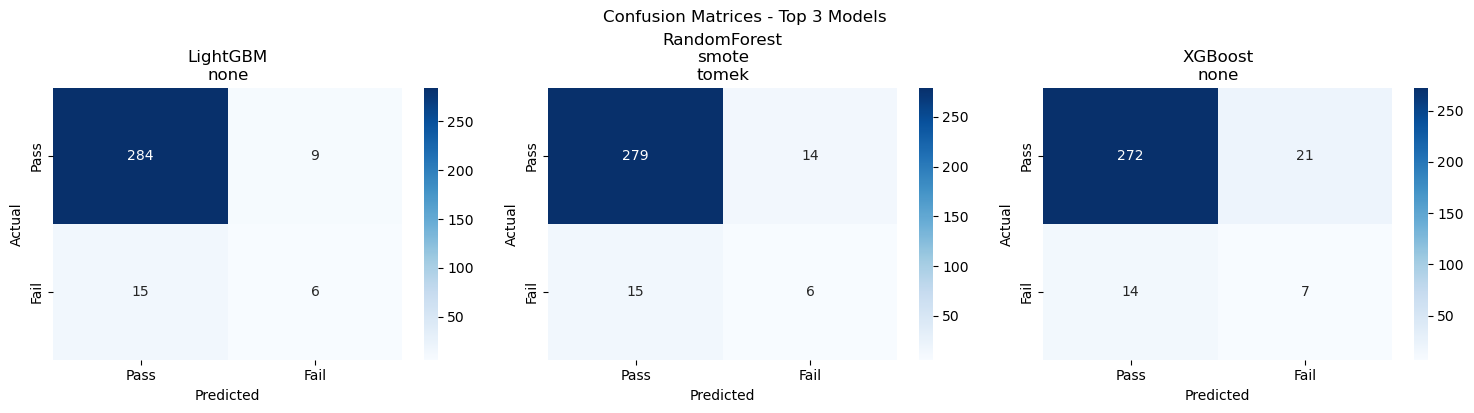

In [22]:
# Cell 21: Confusion matrices for top 3

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

top_3_keys = [f"{row['model']}_{row['resampling']}" for _, row in top_3.iterrows()]

for ax, key in zip(axes, top_3_keys):
    if key in final_models:
        test_pred = final_models[key]['test_pred']
        cm = confusion_matrix(y_test, test_pred)
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                    xticklabels=['Pass', 'Fail'], yticklabels=['Pass', 'Fail'])
        ax.set_title(key.replace('_', '\n'))
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

plt.tight_layout()
plt.suptitle('Confusion Matrices - Top 3 Models', y=1.02)
plt.show()

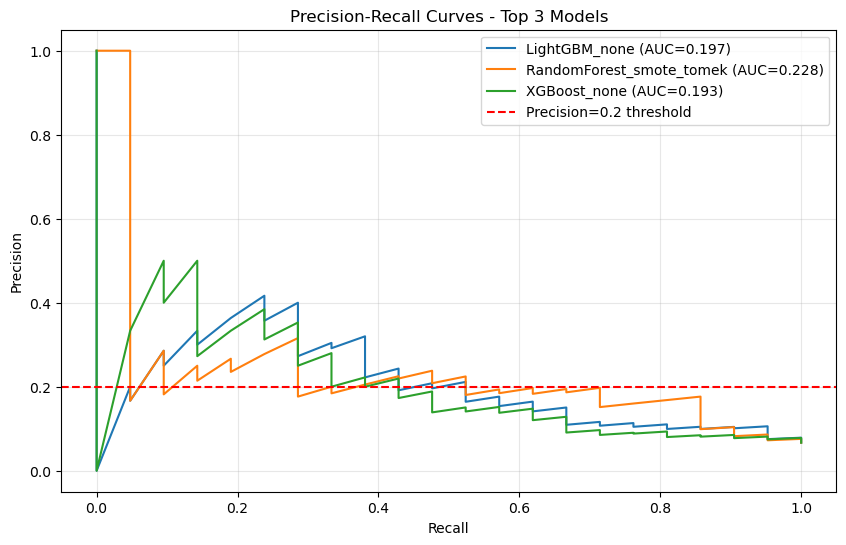

In [23]:
# Cell 22: PR curves for top 3

plt.figure(figsize=(10, 6))

for key in top_3_keys:
    if key in final_models:
        test_proba = final_models[key]['test_proba']
        precision, recall, _ = precision_recall_curve(y_test, test_proba)
        pr_auc = auc(recall, precision)
        plt.plot(recall, precision, label=f"{key} (AUC={pr_auc:.3f})")

plt.axhline(y=0.2, color='r', linestyle='--', label='Precision=0.2 threshold')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Top 3 Models')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.show()

## SHAP Interpretability

**Warning**: Do not change anything after viewing SHAP results. If changes are needed, rerun the entire pipeline.

In [24]:
# Cell 23: Select top 2-3 performers for SHAP analysis

# Select top 3 (accounting for potential winner's curse, we analyze multiple)
shap_models = []

for i, (_, row) in enumerate(top_3.iterrows()):
    key = f"{row['model']}_{row['resampling']}"
    if key in final_models:
        shap_models.append({
            'name': key,
            'model': final_models[key]['model'],
            'threshold': final_models[key]['threshold']
        })

print(f"Models selected for SHAP analysis: {[m['name'] for m in shap_models]}")

Models selected for SHAP analysis: ['LightGBM_none', 'RandomForest_smote_tomek', 'XGBoost_none']



SHAP Analysis: LightGBM_none


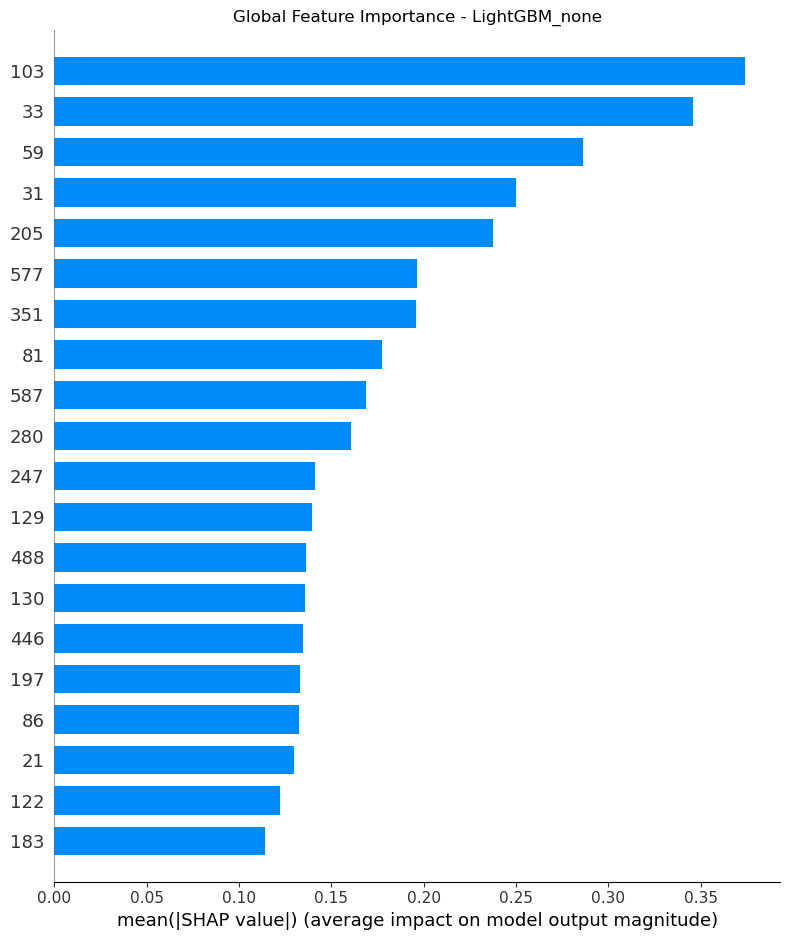

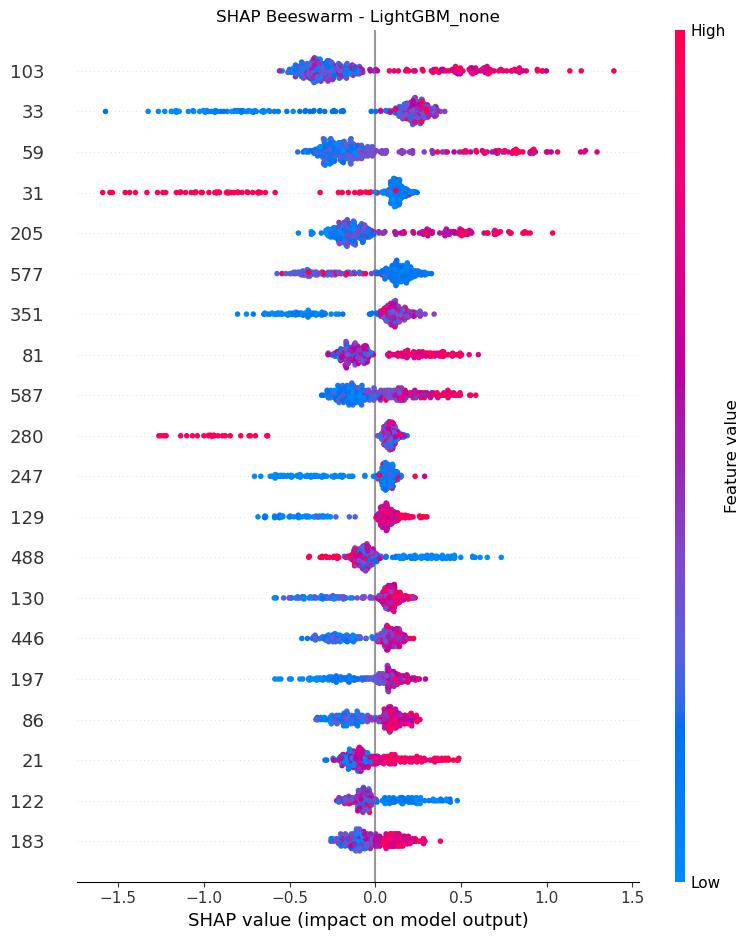


SHAP Analysis: RandomForest_smote_tomek


<Figure size 1000x800 with 0 Axes>

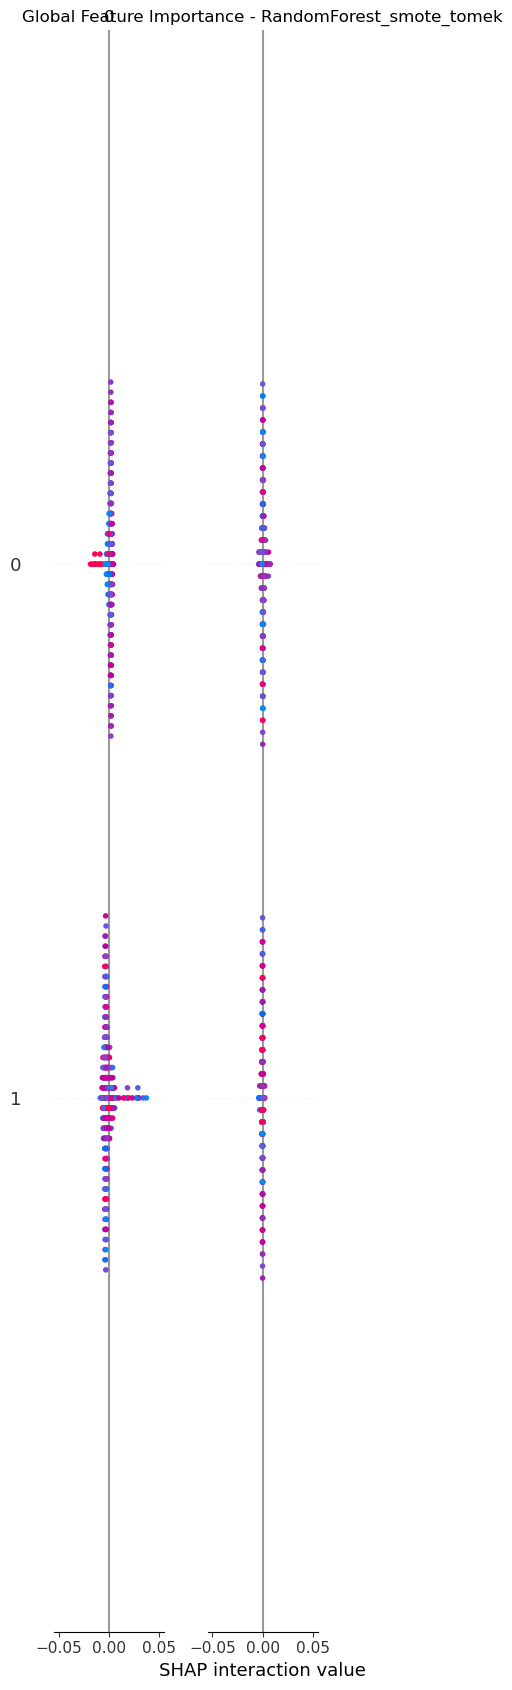

<Figure size 1000x800 with 0 Axes>

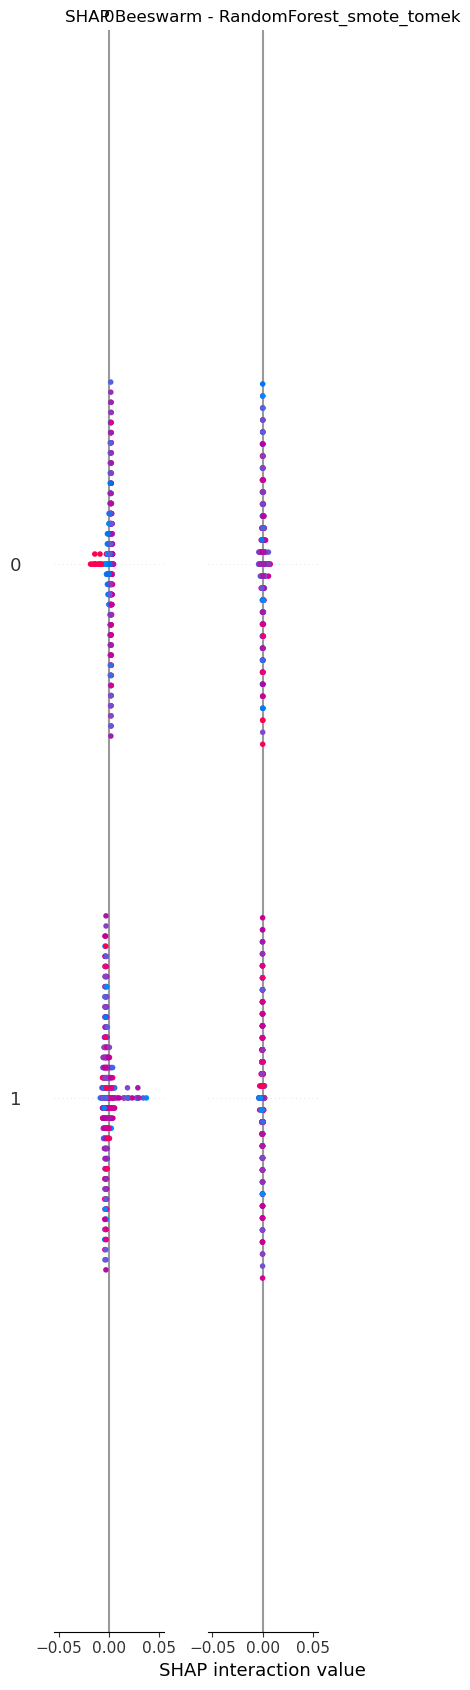


SHAP Analysis: XGBoost_none


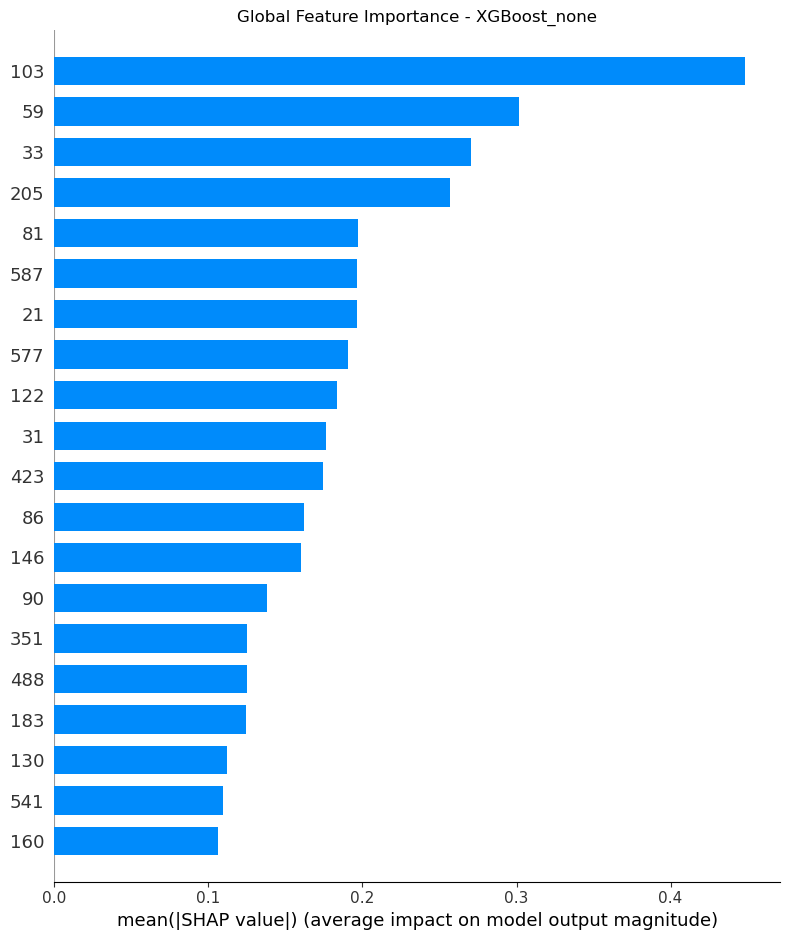

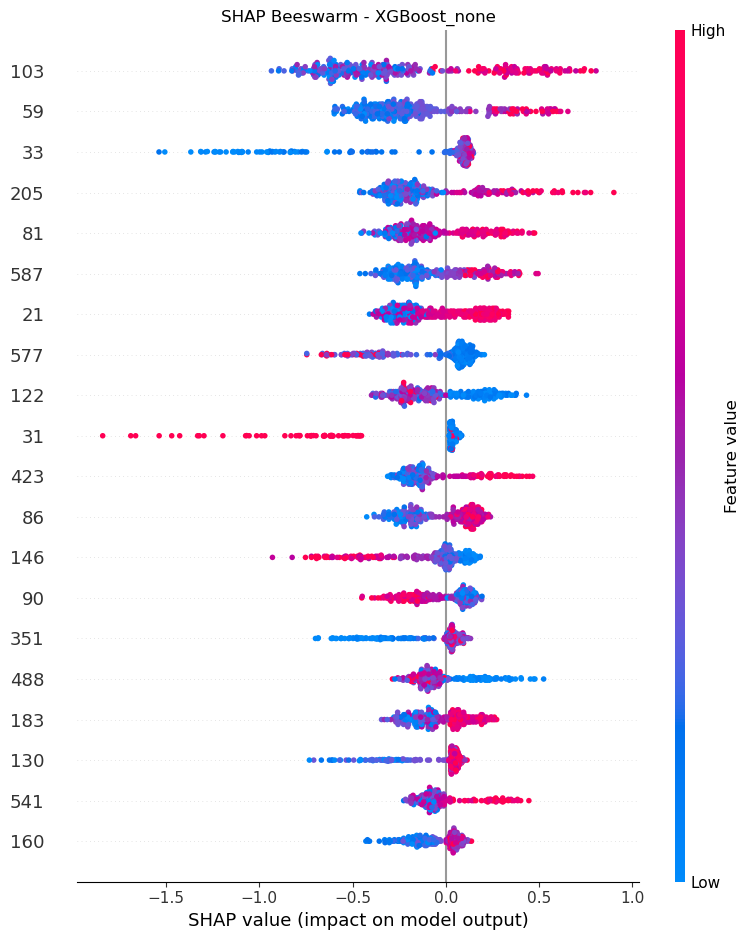

In [25]:
# Cell 24: Global SHAP - Bar and Beeswarm plots

for model_info in shap_models:
    model_name = model_info['name']
    model = model_info['model']
    
    print(f"\n{'='*60}")
    print(f"SHAP Analysis: {model_name}")
    print(f"{'='*60}")
    
    # Create SHAP explainer
    if 'LightGBM' in model_name or 'XGBoost' in model_name or 'RandomForest' in model_name:
        explainer = shap.TreeExplainer(model)
    else:
        # For Logistic Regression, use a sample for background
        background = shap.sample(X_train_final, 100, random_state=42)
        explainer = shap.LinearExplainer(model, background)
    
    # Calculate SHAP values on test set
    shap_values = explainer.shap_values(X_test_final)
    
    # Handle different SHAP output formats
    if isinstance(shap_values, list):
        # For classifiers that return [class_0, class_1]
        shap_values_display = shap_values[1]  # Use positive class
    else:
        shap_values_display = shap_values
    
    # Bar plot (global feature importance)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_display, X_test_final, plot_type='bar', 
                      max_display=20, show=False)
    plt.title(f'Global Feature Importance - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Beeswarm plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_display, X_test_final, max_display=20, show=False)
    plt.title(f'SHAP Beeswarm - {model_name}')
    plt.tight_layout()
    plt.show()
    
    # Store for later use
    model_info['explainer'] = explainer
    model_info['shap_values'] = shap_values_display

In [26]:
# Cell 25: Local SHAP - Waterfall and Force plots for example cases

# Use first model for local explanations
model_info = shap_models[0]
model_name = model_info['name']
model = model_info['model']
threshold = model_info['threshold']
shap_values_display = model_info['shap_values']

print(f"\nLocal explanations for: {model_name}")
print("="*60)

# Get predictions
test_proba = model.predict_proba(X_test_final)[:, 1]
test_pred = (test_proba >= threshold).astype(int)

# Find example cases
tp_idx = np.where((test_pred == 1) & (y_test.values == 1))[0]
fn_idx = np.where((test_pred == 0) & (y_test.values == 1))[0]
fp_idx = np.where((test_pred == 1) & (y_test.values == 0))[0]

print(f"True Positives: {len(tp_idx)}")
print(f"False Negatives: {len(fn_idx)}")
print(f"False Positives: {len(fp_idx)}")

# Create SHAP Explanation object for waterfall plots
shap_exp = shap.Explanation(
    values=shap_values_display,
    base_values=model_info['explainer'].expected_value if not isinstance(model_info['explainer'].expected_value, list) 
                else model_info['explainer'].expected_value[1],
    data=X_test_final.values,
    feature_names=X_test_final.columns.tolist()
)


Local explanations for: LightGBM_none
True Positives: 6
False Negatives: 15
False Positives: 9



True Positive Example (index 60):
  Predicted probability: 0.314
  Actual: Fail


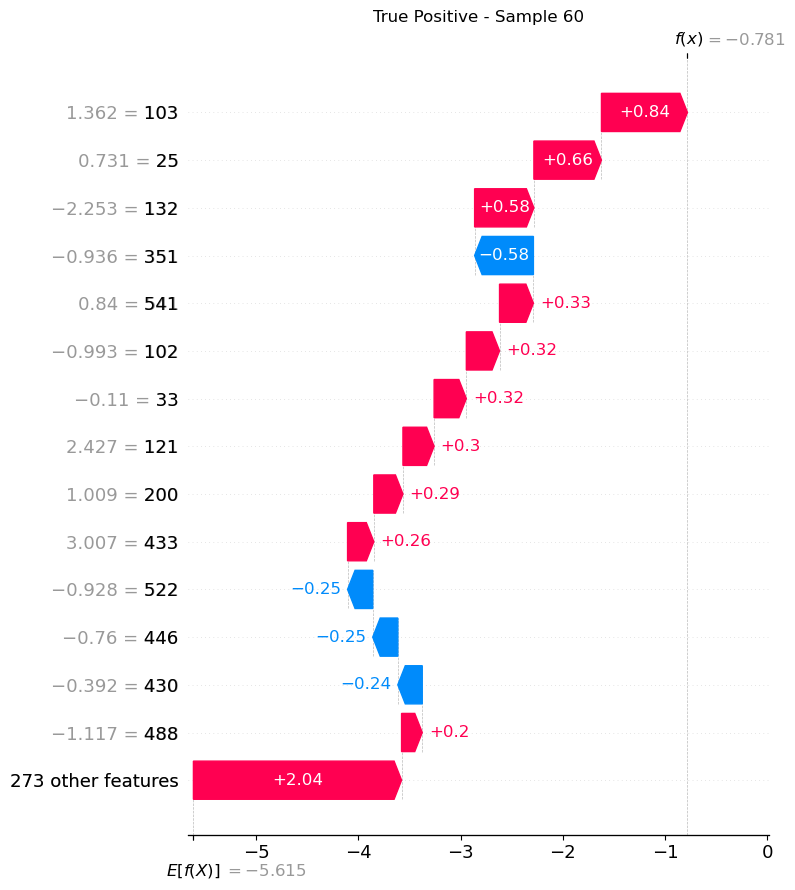


False Negative Example (index 37):
  Predicted probability: 0.002
  Actual: Fail (missed!)


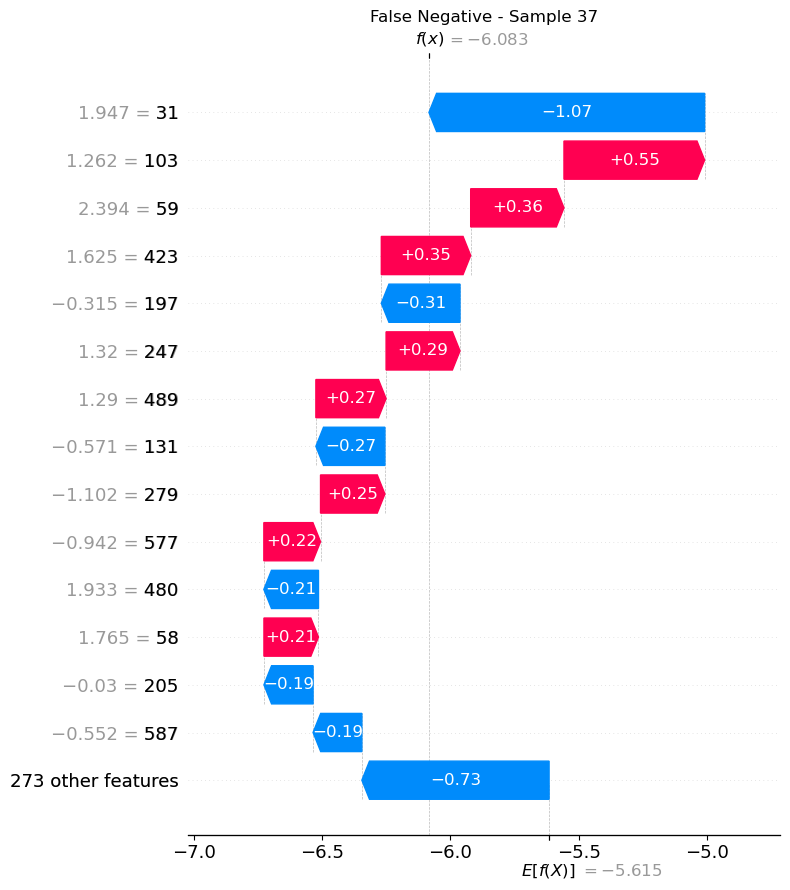


False Positive Example (index 58):
  Predicted probability: 0.154
  Actual: Pass (false alarm)


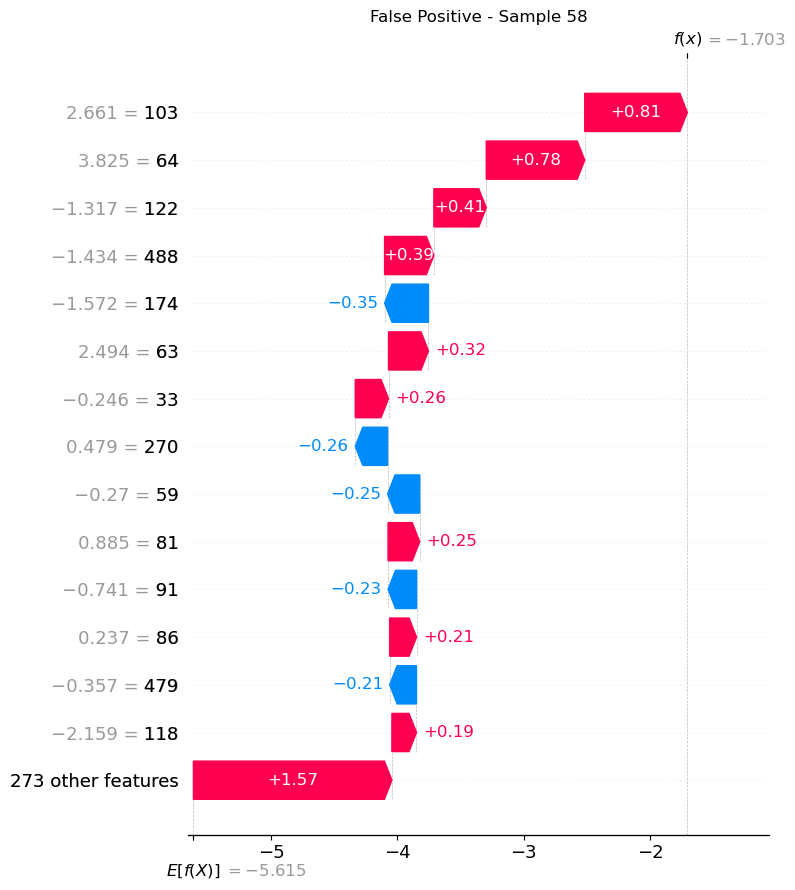

In [27]:
# Cell 25b: Waterfall plots for TP, FN, FP examples

# True Positive example
if len(tp_idx) > 0:
    idx = tp_idx[0]
    print(f"\nTrue Positive Example (index {idx}):")
    print(f"  Predicted probability: {test_proba[idx]:.3f}")
    print(f"  Actual: Fail")
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
    plt.title(f'True Positive - Sample {idx}')
    plt.tight_layout()
    plt.show()

# False Negative example
if len(fn_idx) > 0:
    idx = fn_idx[0]
    print(f"\nFalse Negative Example (index {idx}):")
    print(f"  Predicted probability: {test_proba[idx]:.3f}")
    print(f"  Actual: Fail (missed!)")
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
    plt.title(f'False Negative - Sample {idx}')
    plt.tight_layout()
    plt.show()

# False Positive example
if len(fp_idx) > 0:
    idx = fp_idx[0]
    print(f"\nFalse Positive Example (index {idx}):")
    print(f"  Predicted probability: {test_proba[idx]:.3f}")
    print(f"  Actual: Pass (false alarm)")
    
    plt.figure(figsize=(10, 6))
    shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
    plt.title(f'False Positive - Sample {idx}')
    plt.tight_layout()
    plt.show()

In [28]:
# Cell 26: Force plots for the same examples

# Initialize JS visualization
shap.initjs()

# Force plot for TP
if len(tp_idx) > 0:
    idx = tp_idx[0]
    print(f"\nForce Plot - True Positive (index {idx}):")
    display(shap.force_plot(
        shap_exp.base_values[idx] if hasattr(shap_exp.base_values, '__len__') and len(shap_exp.base_values) > 1 else shap_exp.base_values,
        shap_exp.values[idx],
        X_test_final.iloc[idx],
        feature_names=X_test_final.columns.tolist()
    ))

# Force plot for FN
if len(fn_idx) > 0:
    idx = fn_idx[0]
    print(f"\nForce Plot - False Negative (index {idx}):")
    display(shap.force_plot(
        shap_exp.base_values[idx] if hasattr(shap_exp.base_values, '__len__') and len(shap_exp.base_values) > 1 else shap_exp.base_values,
        shap_exp.values[idx],
        X_test_final.iloc[idx],
        feature_names=X_test_final.columns.tolist()
    ))


Force Plot - True Positive (index 60):



Force Plot - False Negative (index 37):



Feature Clustering Analysis for: LightGBM_none


82370it [06:26, 208.08it/s]                            


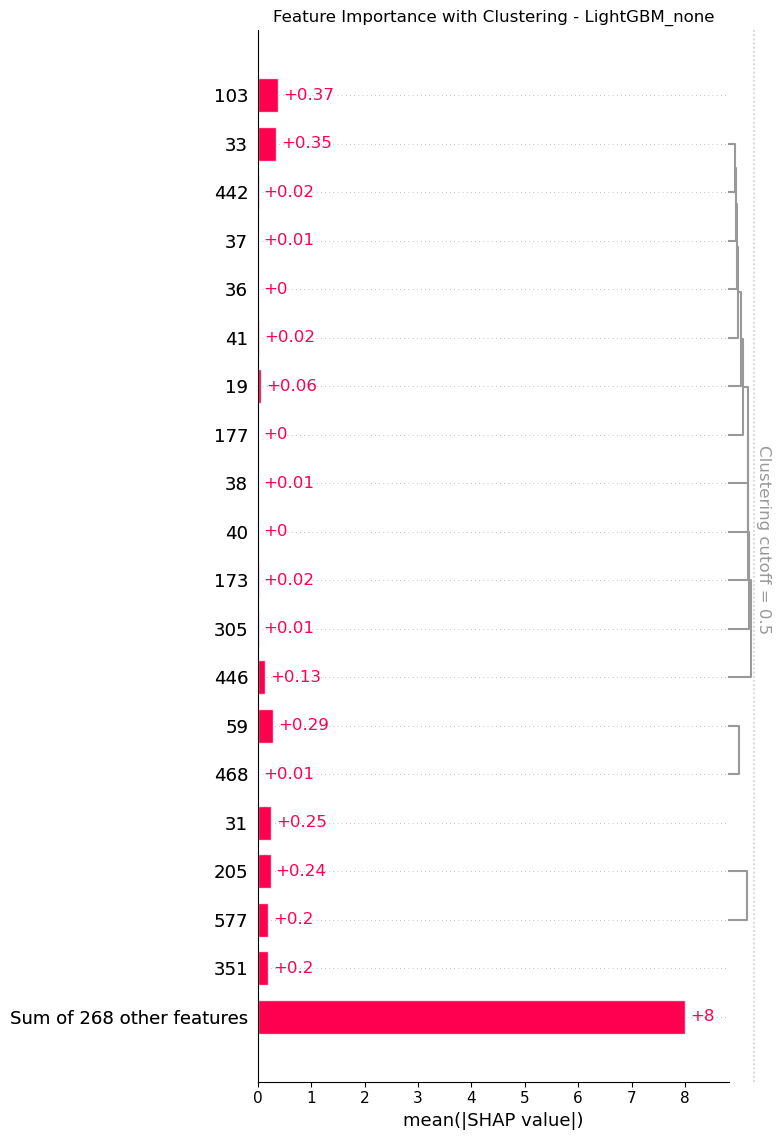

In [29]:
# Cell 27: Feature clustering (correlated features grouped)

model_info = shap_models[0]
shap_values_display = model_info['shap_values']

print(f"\nFeature Clustering Analysis for: {model_info['name']}")
print("="*60)

# Hierarchical clustering of features based on SHAP values
plt.figure(figsize=(12, 8))

# Create clustering plot
clustering = shap.utils.hclust(X_test_final, y_test)

shap.plots.bar(
    shap.Explanation(
        values=shap_values_display,
        base_values=model_info['explainer'].expected_value if not isinstance(model_info['explainer'].expected_value, list) 
                    else model_info['explainer'].expected_value[1],
        data=X_test_final.values,
        feature_names=X_test_final.columns.tolist()
    ),
    max_display=20,
    clustering=clustering,
    clustering_cutoff=0.5,
    show=False
)
plt.title(f'Feature Importance with Clustering - {model_info["name"]}')
plt.tight_layout()
plt.show()

## Summary and Conclusions

In [30]:
# Cell 28: Final summary

print("="*80)
print("FINAL ANALYSIS SUMMARY")
print("="*80)

print("\n1. DATA OVERVIEW:")
print(f"   - Original features: {feature_engineering_log['original_features']}")
print(f"   - Final features after engineering: {len(final_feature_cols_with_indicators)}")
print(f"   - Training samples: {len(y_train)}")
print(f"   - Test samples: {len(y_test)}")
print(f"   - Defect rate: {y_train.mean():.2%}")

print("\n2. BEST MODEL CONFIGURATION:")
best_result = test_results_df.iloc[0]
print(f"   - Model: {best_result['model']}")
print(f"   - Resampling: {best_result['resampling']}")
print(f"   - Threshold (from CV): {best_result['threshold']:.3f}")

print("\n3. TEST SET PERFORMANCE (using fixed threshold from CV):")
print(f"   - F1 Score: {best_result['f1']:.4f}")
print(f"   - PR-AUC: {best_result['pr_auc']:.4f}")
print(f"   - Recall: {best_result['recall']:.4f}")
print(f"   - Precision: {best_result['precision']:.4f}")

print("\n4. KEY INSIGHTS FROM SHAP:")
if shap_models:
    # Get top features
    mean_abs_shap = np.abs(shap_models[0]['shap_values']).mean(axis=0)
    top_features_idx = np.argsort(mean_abs_shap)[-5:][::-1]
    top_features = [X_test_final.columns[i] for i in top_features_idx]
    print(f"   Top 5 most important features:")
    for i, feat in enumerate(top_features, 1):
        print(f"   {i}. {feat}")

print("\n" + "="*80)
print("Analysis complete!")
print("="*80)

FINAL ANALYSIS SUMMARY

1. DATA OVERVIEW:
   - Original features: 590
   - Final features after engineering: 287
   - Training samples: 1253
   - Test samples: 314
   - Defect rate: 6.62%

2. BEST MODEL CONFIGURATION:
   - Model: LightGBM
   - Resampling: none
   - Threshold (from CV): 0.090

3. TEST SET PERFORMANCE (using fixed threshold from CV):
   - F1 Score: 0.3333
   - PR-AUC: 0.2149
   - Recall: 0.2857
   - Precision: 0.4000

4. KEY INSIGHTS FROM SHAP:
   Top 5 most important features:
   1. 103
   2. 33
   3. 59
   4. 31
   5. 205

Analysis complete!


## Defect Difficulty Analysis: Easy vs Hard Cases

Not all defects are equal. Some are consistently detected across multiple models while others evade even the best classifiers. Understanding this structure helps prioritize improvement efforts.

In [31]:
# Cell 29: Analyze prediction overlap across all models for positive cases

print("="*80)
print("DEFECT DIFFICULTY ANALYSIS")
print("="*80)

# Get indices of actual positive cases in test set
positive_test_indices = np.where(y_test.values == 1)[0]
print(f"\nTotal defects in test set: {len(positive_test_indices)}")

# Collect predictions from all models for each positive case
defect_predictions = {}

for key, model_data in final_models.items():
    test_pred = model_data['test_pred']
    for idx in positive_test_indices:
        if idx not in defect_predictions:
            defect_predictions[idx] = {'models_detected': [], 'models_missed': []}
        
        if test_pred[idx] == 1:
            defect_predictions[idx]['models_detected'].append(key)
        else:
            defect_predictions[idx]['models_missed'].append(key)

# Calculate detection rate for each defect
defect_difficulty = []
for idx in positive_test_indices:
    n_detected = len(defect_predictions[idx]['models_detected'])
    n_total = len(final_models)
    detection_rate = n_detected / n_total
    
    defect_difficulty.append({
        'test_index': idx,
        'original_index': y_test.index[idx],
        'n_models_detected': n_detected,
        'n_models_total': n_total,
        'detection_rate': detection_rate,
        'models_detected': defect_predictions[idx]['models_detected'],
        'models_missed': defect_predictions[idx]['models_missed']
    })

defect_df = pd.DataFrame(defect_difficulty)
defect_df = defect_df.sort_values('detection_rate', ascending=False)

print("\nDefect Detection Summary by Case:")
print("-"*80)
for _, row in defect_df.iterrows():
    difficulty = "EASY" if row['detection_rate'] >= 0.5 else ("MEDIUM" if row['detection_rate'] >= 0.2 else "HARD")
    print(f"Defect at test idx {row['test_index']:3d}: {row['n_models_detected']:2d}/{row['n_models_total']} models detected ({row['detection_rate']:.1%}) - {difficulty}")


DEFECT DIFFICULTY ANALYSIS

Total defects in test set: 21

Defect Detection Summary by Case:
--------------------------------------------------------------------------------
Defect at test idx  60: 14/16 models detected (87.5%) - EASY
Defect at test idx 249: 11/16 models detected (68.8%) - EASY
Defect at test idx 185:  9/16 models detected (56.2%) - EASY
Defect at test idx 181:  7/16 models detected (43.8%) - MEDIUM
Defect at test idx 184:  7/16 models detected (43.8%) - MEDIUM
Defect at test idx 187:  6/16 models detected (37.5%) - MEDIUM
Defect at test idx 110:  6/16 models detected (37.5%) - MEDIUM
Defect at test idx  78:  6/16 models detected (37.5%) - MEDIUM
Defect at test idx 239:  4/16 models detected (25.0%) - MEDIUM
Defect at test idx  88:  4/16 models detected (25.0%) - MEDIUM
Defect at test idx  56:  2/16 models detected (12.5%) - HARD
Defect at test idx 276:  1/16 models detected (6.2%) - HARD
Defect at test idx  37:  1/16 models detected (6.2%) - HARD
Defect at test idx 14

In [32]:
# Cell 30: Categorize defects into Easy, Medium, Hard

# Define difficulty categories
easy_defects = defect_df[defect_df['detection_rate'] >= 0.5]
medium_defects = defect_df[(defect_df['detection_rate'] >= 0.2) & (defect_df['detection_rate'] < 0.5)]
hard_defects = defect_df[defect_df['detection_rate'] < 0.2]

print("="*80)
print("DEFECT DIFFICULTY CATEGORIES")
print("="*80)

print(f"\n📗 EASY DEFECTS (≥50% of models detect): {len(easy_defects)} cases")
print(f"   These defects have clear signatures that most models can identify.")
if len(easy_defects) > 0:
    print(f"   Test indices: {easy_defects['test_index'].tolist()}")
    for _, row in easy_defects.iterrows():
        print(f"   - Idx {row['test_index']}: Detected by {row['n_models_detected']} models including: {', '.join(row['models_detected'][:5])}")

print(f"\n📙 MEDIUM DEFECTS (20-50% of models detect): {len(medium_defects)} cases")
print(f"   These defects are detectable but require the right model configuration.")
if len(medium_defects) > 0:
    print(f"   Test indices: {medium_defects['test_index'].tolist()}")
    for _, row in medium_defects.iterrows():
        detected_models = row['models_detected'][:3] if len(row['models_detected']) > 0 else ['None']
        print(f"   - Idx {row['test_index']}: Detected by {row['n_models_detected']} models: {', '.join(detected_models)}")

print(f"\n📕 HARD DEFECTS (<20% of models detect): {len(hard_defects)} cases")
print(f"   These defects have unusual signatures that current features cannot capture.")
if len(hard_defects) > 0:
    print(f"   Test indices: {hard_defects['test_index'].tolist()}")
    for _, row in hard_defects.iterrows():
        if row['n_models_detected'] > 0:
            print(f"   - Idx {row['test_index']}: Only detected by: {', '.join(row['models_detected'])}")
        else:
            print(f"   - Idx {row['test_index']}: MISSED BY ALL MODELS")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"Easy defects:   {len(easy_defects):2d} ({len(easy_defects)/len(defect_df)*100:.1f}%) - Reliably detectable")
print(f"Medium defects: {len(medium_defects):2d} ({len(medium_defects)/len(defect_df)*100:.1f}%) - Partially detectable")
print(f"Hard defects:   {len(hard_defects):2d} ({len(hard_defects)/len(defect_df)*100:.1f}%) - Need new approaches")

DEFECT DIFFICULTY CATEGORIES

📗 EASY DEFECTS (≥50% of models detect): 3 cases
   These defects have clear signatures that most models can identify.
   Test indices: [60, 249, 185]
   - Idx 60: Detected by 14 models including: LightGBM_smote_tomek, XGBoost_smote_tomek, XGBoost_none, RandomForest_undersample, RandomForest_smote_tomek
   - Idx 249: Detected by 11 models including: LightGBM_smote_tomek, XGBoost_smote_tomek, XGBoost_none, RandomForest_undersample, RandomForest_smote_tomek
   - Idx 185: Detected by 9 models including: LightGBM_smote_tomek, XGBoost_smote_tomek, XGBoost_none, RandomForest_undersample, RandomForest_smote_tomek

📙 MEDIUM DEFECTS (20-50% of models detect): 7 cases
   These defects are detectable but require the right model configuration.
   Test indices: [181, 184, 187, 110, 78, 239, 88]
   - Idx 181: Detected by 7 models: XGBoost_none, RandomForest_undersample, RandomForest_smote_tomek
   - Idx 184: Detected by 7 models: LightGBM_smote_tomek, XGBoost_smote_tomek

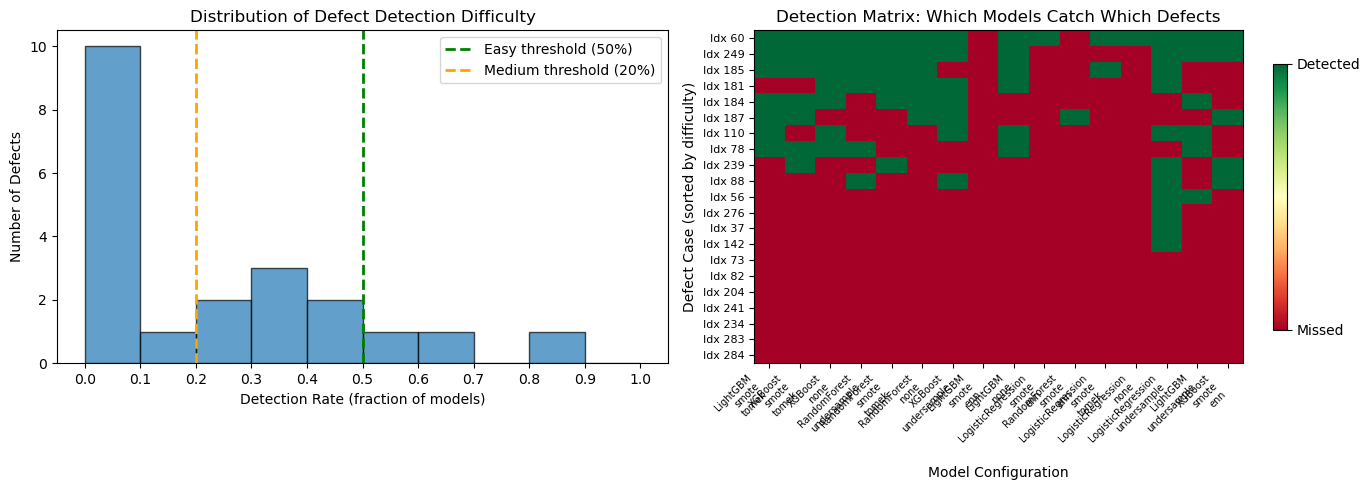


Detection Rate Statistics:
  Mean: 23.5%
  Median: 12.5%
  Min: 0.0%
  Max: 87.5%


In [33]:
# Cell 31: Visualize detection rate distribution

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of detection rates
ax1 = axes[0]
detection_rates = defect_df['detection_rate'].values
ax1.hist(detection_rates, bins=np.arange(0, 1.1, 0.1), edgecolor='black', alpha=0.7)
ax1.axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='Easy threshold (50%)')
ax1.axvline(x=0.2, color='orange', linestyle='--', linewidth=2, label='Medium threshold (20%)')
ax1.set_xlabel('Detection Rate (fraction of models)')
ax1.set_ylabel('Number of Defects')
ax1.set_title('Distribution of Defect Detection Difficulty')
ax1.legend()
ax1.set_xticks(np.arange(0, 1.1, 0.1))

# Stacked bar showing which models detect which defects
ax2 = axes[1]
model_names = list(final_models.keys())

# Create matrix: rows = defects (sorted by difficulty), cols = models
detection_matrix = np.zeros((len(defect_df), len(model_names)))
for i, (_, row) in enumerate(defect_df.iterrows()):
    for j, model in enumerate(model_names):
        if model in row['models_detected']:
            detection_matrix[i, j] = 1

# Plot heatmap
im = ax2.imshow(detection_matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
ax2.set_xlabel('Model Configuration')
ax2.set_ylabel('Defect Case (sorted by difficulty)')
ax2.set_title('Detection Matrix: Which Models Catch Which Defects')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels([m.replace('_', '\n') for m in model_names], rotation=45, ha='right', fontsize=7)
ax2.set_yticks(range(len(defect_df)))
ax2.set_yticklabels([f"Idx {row['test_index']}" for _, row in defect_df.iterrows()], fontsize=8)

# Add colorbar
cbar = plt.colorbar(im, ax=ax2, shrink=0.8)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(['Missed', 'Detected'])

plt.tight_layout()
plt.show()

# Print detection rate statistics
print("\nDetection Rate Statistics:")
print(f"  Mean: {detection_rates.mean():.1%}")
print(f"  Median: {np.median(detection_rates):.1%}")
print(f"  Min: {detection_rates.min():.1%}")
print(f"  Max: {detection_rates.max():.1%}")

SHAP ANALYSIS BY DEFECT DIFFICULTY
Using model: LightGBM_none

📊 EASY DEFECT - Test Index 249
Detection rate: 68.8% (11/16 models)
Predicted probability (by LightGBM_none): 0.100
Threshold: 0.090
This model's prediction: DETECTED
Models that detected it: LightGBM_smote_tomek, XGBoost_smote_tomek, XGBoost_none, RandomForest_undersample, RandomForest_smote_tomek


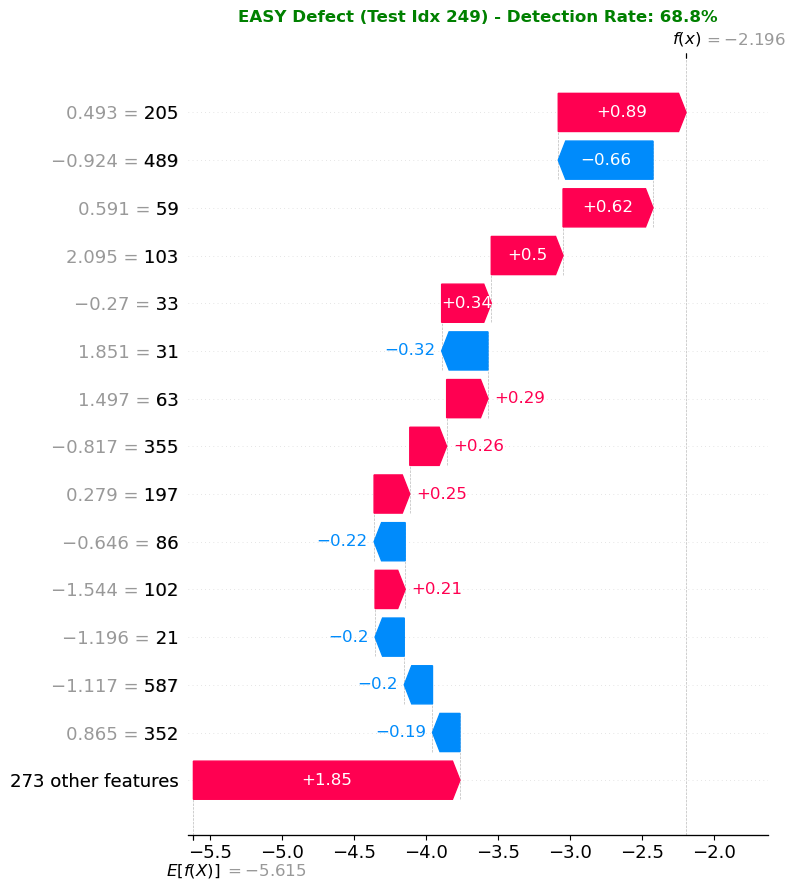


📊 MEDIUM DEFECT - Test Index 187
Detection rate: 37.5% (6/16 models)
Predicted probability (by LightGBM_none): 0.048
Threshold: 0.090
This model's prediction: MISSED
Models that detected it: LightGBM_smote_tomek, XGBoost_smote_tomek, RandomForest_none, XGBoost_undersample, RandomForest_smote_enn


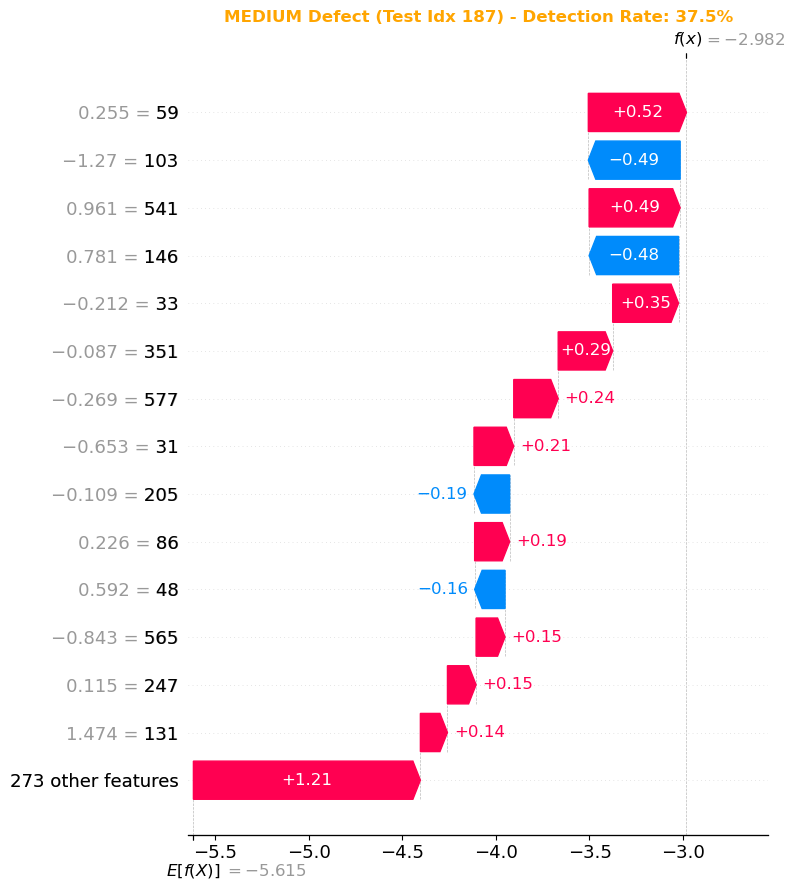


📊 HARD DEFECT - Test Index 284
Detection rate: 0.0% (0/16 models)
Predicted probability (by LightGBM_none): 0.003
Threshold: 0.090
This model's prediction: MISSED


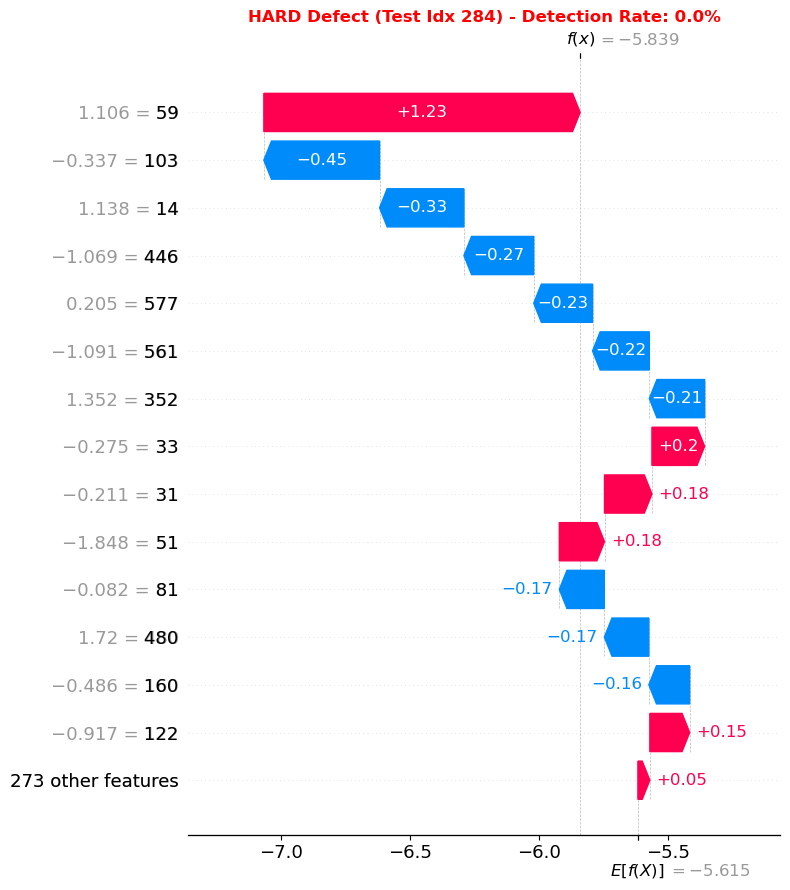

In [34]:
# Cell 32: SHAP Waterfall plots for Easy, Medium, Hard cases

# Use the best model's SHAP explainer
best_model_info = shap_models[0]  # LightGBM_none
shap_values_all = best_model_info['shap_values']
explainer = best_model_info['explainer']
base_value = explainer.expected_value if not isinstance(explainer.expected_value, list) else explainer.expected_value[1]

print("="*80)
print("SHAP ANALYSIS BY DEFECT DIFFICULTY")
print(f"Using model: {best_model_info['name']}")
print("="*80)

# Get test probabilities for context
test_proba = final_models[best_model_info['name']]['test_proba']
threshold = best_model_info['threshold']

# Select representative cases from each category
def get_representative_case(df, category_name):
    """Get the most representative case (middle of the category)"""
    if len(df) == 0:
        return None
    # Sort by detection rate and pick middle
    sorted_df = df.sort_values('detection_rate')
    mid_idx = len(sorted_df) // 2
    return sorted_df.iloc[mid_idx]

easy_case = get_representative_case(easy_defects, "Easy") if len(easy_defects) > 0 else None
medium_case = get_representative_case(medium_defects, "Medium") if len(medium_defects) > 0 else None
hard_case = get_representative_case(hard_defects, "Hard") if len(hard_defects) > 0 else None

# Create SHAP Explanation object
shap_exp = shap.Explanation(
    values=shap_values_all,
    base_values=base_value,
    data=X_test_final.values,
    feature_names=X_test_final.columns.tolist()
)

# Plot waterfall for each difficulty level
cases_to_plot = [
    ("EASY", easy_case, "green"),
    ("MEDIUM", medium_case, "orange"),
    ("HARD", hard_case, "red")
]

for difficulty, case, color in cases_to_plot:
    if case is not None:
        idx = case['test_index']
        prob = test_proba[idx]
        detected_by = case['n_models_detected']
        total_models = case['n_models_total']
        
        print(f"\n{'='*60}")
        print(f"📊 {difficulty} DEFECT - Test Index {idx}")
        print(f"{'='*60}")
        print(f"Detection rate: {case['detection_rate']:.1%} ({detected_by}/{total_models} models)")
        print(f"Predicted probability (by {best_model_info['name']}): {prob:.3f}")
        print(f"Threshold: {threshold:.3f}")
        print(f"This model's prediction: {'DETECTED' if prob >= threshold else 'MISSED'}")
        if detected_by > 0:
            print(f"Models that detected it: {', '.join(case['models_detected'][:5])}")
        
        plt.figure(figsize=(12, 6))
        shap.plots.waterfall(shap_exp[idx], max_display=15, show=False)
        plt.title(f'{difficulty} Defect (Test Idx {idx}) - Detection Rate: {case["detection_rate"]:.1%}', 
                  fontsize=12, fontweight='bold', color=color)
        plt.tight_layout()
        plt.show()
    else:
        print(f"\n⚠️ No {difficulty} defect cases found in this test set.")

In [35]:
# Cell 33: Compare feature values between Easy and Hard defects

print("="*80)
print("FEATURE COMPARISON: EASY vs HARD DEFECTS")
print("="*80)

# Get indices for each category
easy_indices = easy_defects['test_index'].tolist() if len(easy_defects) > 0 else []
hard_indices = hard_defects['test_index'].tolist() if len(hard_defects) > 0 else []

# Get top features from SHAP
mean_abs_shap = np.abs(shap_values_all).mean(axis=0)
top_10_feature_idx = np.argsort(mean_abs_shap)[-10:][::-1]
top_10_features = [X_test_final.columns[i] for i in top_10_feature_idx]

print(f"\nAnalyzing top 10 SHAP features: {top_10_features}")

if len(easy_indices) > 0 and len(hard_indices) > 0:
    # Compare feature statistics
    comparison_data = []
    
    for feat in top_10_features:
        easy_values = X_test_final.iloc[easy_indices][feat].values
        hard_values = X_test_final.iloc[hard_indices][feat].values
        normal_values = X_test_final[y_test.values == 0][feat].values  # Non-defect cases
        
        comparison_data.append({
            'Feature': feat,
            'Easy Mean': np.mean(easy_values),
            'Easy Std': np.std(easy_values),
            'Hard Mean': np.mean(hard_values),
            'Hard Std': np.std(hard_values),
            'Normal Mean': np.mean(normal_values),
            'Normal Std': np.std(normal_values),
            'Easy vs Normal': (np.mean(easy_values) - np.mean(normal_values)) / (np.std(normal_values) + 1e-10),
            'Hard vs Normal': (np.mean(hard_values) - np.mean(normal_values)) / (np.std(normal_values) + 1e-10)
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\nFeature Statistics (standardized values):")
    print("-"*80)
    print(comparison_df[['Feature', 'Easy Mean', 'Hard Mean', 'Normal Mean', 'Easy vs Normal', 'Hard vs Normal']].to_string(index=False))
    
    print("\n" + "="*80)
    print("KEY INSIGHT:")
    print("="*80)
    print("'Easy vs Normal' shows how many std deviations easy defects differ from normal.")
    print("'Hard vs Normal' shows how many std deviations hard defects differ from normal.")
    print("\nIf Easy defects show large deviations but Hard defects don't, the hard defects")
    print("have 'normal-looking' sensor readings - they may require different features to detect.")
    
else:
    print("\n⚠️ Need both Easy and Hard defect cases for comparison.")

FEATURE COMPARISON: EASY vs HARD DEFECTS

Analyzing top 10 SHAP features: ['103', '33', '59', '31', '205', '577', '351', '81', '587', '280']

Feature Statistics (standardized values):
--------------------------------------------------------------------------------
Feature  Easy Mean  Hard Mean  Normal Mean  Easy vs Normal  Hard vs Normal
    103   1.284228   0.092931    -0.024342        1.181876        0.105918
     33  -0.168926   1.904535    -0.039001       -0.169053        2.528855
     59  -0.012367   0.927155    -0.165338        0.206113        1.472027
     31   0.326382  -0.188626     0.075201        0.243902       -0.256182
    205   0.059685  -0.095178    -0.049117        0.194599       -0.082383
    577  -0.249006  -0.024049     0.063196       -0.259712       -0.072576
    351  -0.498217  -0.059754     0.196656       -0.328502       -0.121218
     81  -1.020324   0.087046    -0.007736       -0.873879        0.081799
    587  -0.473706  -0.062973     0.055799       -0.443251  

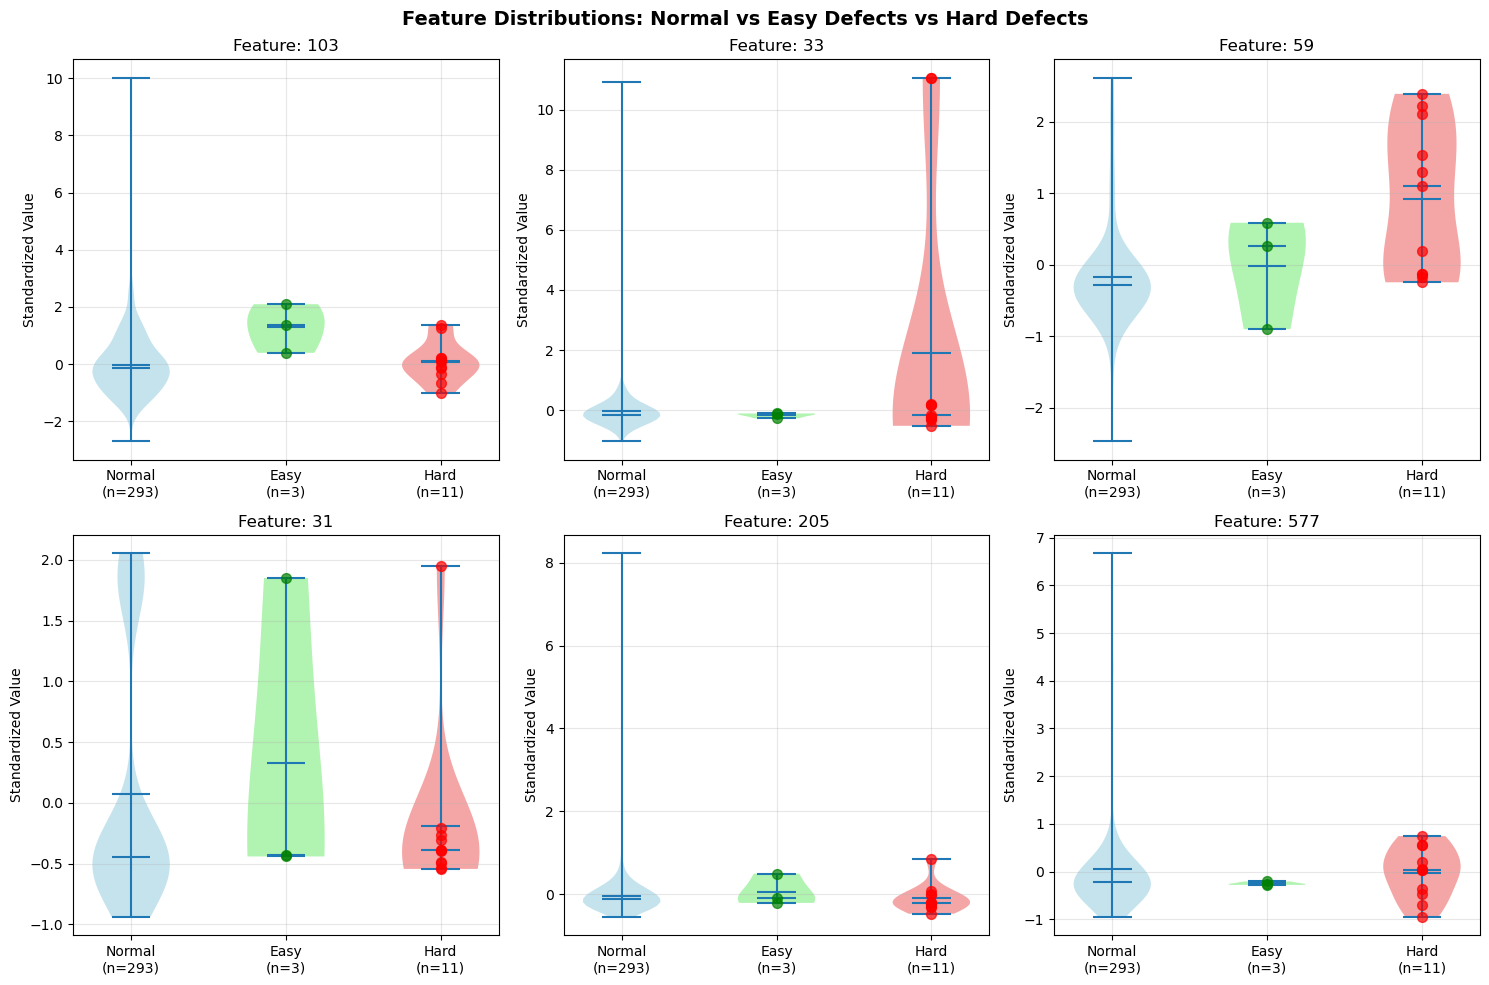


💡 INTERPRETATION:
- Green points (Easy defects): Clearly separated from Normal distribution
- Red points (Hard defects): May overlap with Normal distribution
- If Hard defects overlap with Normal, current features cannot distinguish them


In [36]:
# Cell 34: Visualize feature distributions for Easy vs Hard defects

if len(easy_indices) > 0 and len(hard_indices) > 0:
    # Select top 6 features for visualization
    top_6_features = top_10_features[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for ax, feat in zip(axes, top_6_features):
        # Get values for each group
        normal_vals = X_test_final[y_test.values == 0][feat].values
        easy_vals = X_test_final.iloc[easy_indices][feat].values
        hard_vals = X_test_final.iloc[hard_indices][feat].values
        
        # Create violin plots or box plots
        data = [normal_vals, easy_vals, hard_vals]
        positions = [1, 2, 3]
        
        parts = ax.violinplot(data, positions=positions, showmeans=True, showmedians=True)
        
        # Color the violins
        colors = ['lightblue', 'lightgreen', 'lightcoral']
        for pc, color in zip(parts['bodies'], colors):
            pc.set_facecolor(color)
            pc.set_alpha(0.7)
        
        # Add scatter points for Easy and Hard
        ax.scatter([2]*len(easy_vals), easy_vals, c='green', s=50, alpha=0.7, label='Easy defects', zorder=5)
        ax.scatter([3]*len(hard_vals), hard_vals, c='red', s=50, alpha=0.7, label='Hard defects', zorder=5)
        
        ax.set_xticks(positions)
        ax.set_xticklabels(['Normal\n(n={})'.format(len(normal_vals)), 
                            'Easy\n(n={})'.format(len(easy_vals)), 
                            'Hard\n(n={})'.format(len(hard_vals))])
        ax.set_title(f'Feature: {feat}')
        ax.set_ylabel('Standardized Value')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Feature Distributions: Normal vs Easy Defects vs Hard Defects', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\n💡 INTERPRETATION:")
    print("- Green points (Easy defects): Clearly separated from Normal distribution")
    print("- Red points (Hard defects): May overlap with Normal distribution")
    print("- If Hard defects overlap with Normal, current features cannot distinguish them")
else:
    print("⚠️ Need both Easy and Hard defect cases for visualization.")

In [37]:
# Cell 35: Recommendations for Stakeholders and Engineers

print("="*80)
print("RECOMMENDATIONS FOR STAKEHOLDERS AND ENGINEERS")
print("="*80)

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│                        DEFECT DIFFICULTY SUMMARY                            │
└─────────────────────────────────────────────────────────────────────────────┘
""")

n_easy = len(easy_defects)
n_medium = len(medium_defects)
n_hard = len(hard_defects)
n_total = len(defect_df)

print(f"Of the {n_total} defects in the test set:")
print(f"  ✅ {n_easy} ({n_easy/n_total*100:.0f}%) are EASY to detect - reliably caught by most models")
print(f"  ⚠️  {n_medium} ({n_medium/n_total*100:.0f}%) are MEDIUM difficulty - caught by some models")
print(f"  ❌ {n_hard} ({n_hard/n_total*100:.0f}%) are HARD to detect - missed by most/all models")

print("""
┌─────────────────────────────────────────────────────────────────────────────┐
│                     WHAT THIS MEANS FOR YOUR PROCESS                        │
└─────────────────────────────────────────────────────────────────────────────┘

1. EASY DEFECTS - Low-Hanging Fruit 🍎
   - These defects show CLEAR anomalies in key sensors
   - Current monitoring with sensor thresholds would catch most of these
   - Recommendation: Implement automated alerts when sensors 103, 33, 59 
     exceed their normal operating ranges

2. MEDIUM DEFECTS - Model-Dependent Detection 🔍
   - These defects have subtle signatures that require ML to detect
   - Different model configurations catch different subsets
   - Recommendation: Consider an ensemble approach or human review
     for cases near the decision boundary

3. HARD DEFECTS - The Blind Spots 🔮
   - These defects have NORMAL-LOOKING sensor readings
   - Current sensors may not capture the root cause
   
   POSSIBLE REASONS:
   a) Different failure mode: These defects may arise from a different 
      physical process not captured by current sensors
   b) Delayed effect: The anomaly may occur earlier/later than when 
      measurements are taken
   c) Missing sensors: Key process parameters may not be monitored
   d) Interaction effects: The defect may require specific combinations
      of sensor values not easily detected by current features

┌─────────────────────────────────────────────────────────────────────────────┐
│                     RECOMMENDED ACTIONS FOR ENGINEERS                       │
└─────────────────────────────────────────────────────────────────────────────┘

1. INVESTIGATE HARD CASES:
   - Pull the actual wafers/units corresponding to hard defect cases
   - Conduct root cause analysis: What caused these specific failures?
   - Compare with easy defect cases: How are the failure modes different?

2. SENSOR REVIEW:
   - Are there process steps without sensor coverage?
   - Could we add sensors for temperature/pressure/flow at critical points?
   - Consider time-series features: rate of change, variance, patterns

3. FEATURE ENGINEERING COLLABORATION:
   - What domain knowledge could help create new features?
   - Are there known "recipes" or process windows that correlate with quality?
   - Could we incorporate upstream/downstream process data?

4. DATA COLLECTION:
   - For the hard defect cases, what additional data could we collect?
   - Would higher-frequency sampling help?
   - Are there visual inspection features we could quantify?
""")

# Print specific indices for investigation
print("┌─────────────────────────────────────────────────────────────────────────────┐")
print("│                     SPECIFIC CASES TO INVESTIGATE                           │")
print("└─────────────────────────────────────────────────────────────────────────────┘")
print()
print("HARD DEFECTS (require investigation):")
if len(hard_defects) > 0:
    for _, row in hard_defects.iterrows():
        original_idx = row['original_index']
        print(f"  - Original dataset row {original_idx}: Missed by {16-row['n_models_detected']}/16 models")
else:
    print("  (None in this test set)")

print()
print("EASY DEFECTS (for comparison - what makes them detectable?):")
if len(easy_defects) > 0:
    for _, row in easy_defects.iterrows():
        original_idx = row['original_index']
        print(f"  - Original dataset row {original_idx}: Detected by {row['n_models_detected']}/16 models")
else:
    print("  (None in this test set)")

RECOMMENDATIONS FOR STAKEHOLDERS AND ENGINEERS

┌─────────────────────────────────────────────────────────────────────────────┐
│                        DEFECT DIFFICULTY SUMMARY                            │
└─────────────────────────────────────────────────────────────────────────────┘

Of the 21 defects in the test set:
  ✅ 3 (14%) are EASY to detect - reliably caught by most models
  ⚠️  7 (33%) are MEDIUM difficulty - caught by some models
  ❌ 11 (52%) are HARD to detect - missed by most/all models

┌─────────────────────────────────────────────────────────────────────────────┐
│                     WHAT THIS MEANS FOR YOUR PROCESS                        │
└─────────────────────────────────────────────────────────────────────────────┘

1. EASY DEFECTS - Low-Hanging Fruit 🍎
   - These defects show CLEAR anomalies in key sensors
   - Current monitoring with sensor thresholds would catch most of these
   - Recommendation: Implement automated alerts when sensors 103, 33, 59 
     excee

In [52]:
# ============================================================
# MULTI-METHOD FEATURE IMPORTANCE VALIDATION
# ============================================================
# Purpose: Validate SHAP findings with independent methods
# Agreement = confidence, Disagreement = investigate

from sklearn.inspection import permutation_importance
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

print("Computing feature importance using 3 methods...")
print("="*60)

# Get feature names and model from your notebook
feature_names = X_test_final.columns.tolist()
best_model = final_models['LightGBM_none']['model']

# -----------------------------
# Method 1: Permutation Importance
# -----------------------------
print("\n[1/3] Permutation Importance (this may take a minute)...")

perm_result = permutation_importance(
    best_model,
    X_test_final,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='average_precision',
    n_jobs=-1
)

perm_df = pd.DataFrame({
    'feature': feature_names,
    'perm_importance': perm_result.importances_mean,
    'perm_std': perm_result.importances_std
}).sort_values('perm_importance', ascending=False).reset_index(drop=True)

print(f"   Done! Top feature: {perm_df.iloc[0]['feature']}")

# -----------------------------
# Method 2: Tree-Based MDI (Gain)
# -----------------------------
print("\n[2/3] Tree-Based MDI (native feature_importances_)...")

mdi_df = pd.DataFrame({
    'feature': feature_names,
    'mdi_importance': best_model.feature_importances_
}).sort_values('mdi_importance', ascending=False).reset_index(drop=True)

print(f"   Done! Top feature: {mdi_df.iloc[0]['feature']}")

# -----------------------------
# Method 3: SHAP (from previous analysis)
# -----------------------------
print("\n[3/3] SHAP Values (using existing explainer)...")

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_final)

# Handle LightGBM returning list for binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class

shap_df = pd.DataFrame({
    'feature': feature_names,
    'shap_importance': np.abs(shap_values).mean(axis=0)
}).sort_values('shap_importance', ascending=False).reset_index(drop=True)

print(f"   Done! Top feature: {shap_df.iloc[0]['feature']}")

print("\n" + "="*60)
print("All methods computed successfully!")


Computing feature importance using 3 methods...

[1/3] Permutation Importance (this may take a minute)...
   Done! Top feature: 59

[2/3] Tree-Based MDI (native feature_importances_)...
   Done! Top feature: 33

[3/3] SHAP Values (using existing explainer)...
   Done! Top feature: 103

All methods computed successfully!


In [53]:
# ============================================================
# COMPARE RANKINGS ACROSS METHODS (FIXED)
# ============================================================

# Create a clean combined dataframe
combined = pd.DataFrame({'feature': feature_names})

# Add importance scores by matching on feature name
combined = combined.merge(perm_df[['feature', 'perm_importance', 'perm_std']], on='feature')
combined = combined.merge(mdi_df[['feature', 'mdi_importance']], on='feature')
combined = combined.merge(shap_df[['feature', 'shap_importance']], on='feature')

# Compute ranks (1 = most important)
combined['perm_rank'] = combined['perm_importance'].rank(ascending=False)
combined['mdi_rank'] = combined['mdi_importance'].rank(ascending=False)
combined['shap_rank'] = combined['shap_importance'].rank(ascending=False)

# Average rank (lower = more consistently important)
combined['avg_rank'] = combined[['perm_rank', 'mdi_rank', 'shap_rank']].mean(axis=1)

# Rank variance (lower = more agreement)
combined['rank_variance'] = combined[['perm_rank', 'mdi_rank', 'shap_rank']].var(axis=1)

# Sort by average rank
combined_sorted = combined.sort_values('avg_rank').reset_index(drop=True)

# Display top 15 with agreement metrics
print("TOP 15 FEATURES BY CONSENSUS (Average Rank)")
print("="*80)
display_cols = ['feature', 'perm_rank', 'mdi_rank', 'shap_rank', 'avg_rank', 'rank_variance']
print(combined_sorted[display_cols].head(15).to_string(index=False))

print("\n" + "="*80)
print("INTERPRETATION:")
print("  - Low avg_rank = consistently important across methods")
print("  - Low rank_variance = high agreement (confident)")
print("  - High rank_variance = disagreement (investigate further)")


TOP 15 FEATURES BY CONSENSUS (Average Rank)
feature  perm_rank  mdi_rank  shap_rank  avg_rank  rank_variance
     33        6.0       1.0        2.0  3.000000       7.000000
     59        1.0       6.5        3.0  3.500000       7.750000
    205        2.0       3.5        5.0  3.500000       2.250000
    129        7.0       8.5       12.0  9.166667       6.583333
    587       10.0       8.5        9.0  9.166667       0.583333
    197        5.0      12.0       16.0 11.000000      31.000000
    577        8.0      19.0        6.0 11.000000      49.000000
     31       35.0       2.0        4.0 13.666667     342.333333
    247       12.0      24.5       11.0 15.833333      56.583333
    131       18.0      10.0       22.0 16.666667      37.333333
     21        4.0      30.0       18.0 17.333333     169.333333
    460       15.0      12.0       30.0 19.000000      93.000000
    117        9.0      19.0       38.0 22.000000     217.000000
    541        3.0      30.0       34.0 22.333

In [54]:
perm_df.head(15)

,feature,perm_importance,perm_std
0,59,0.055481,0.015095
1,205,0.020736,0.018070
2,541,0.016173,0.005657
3,21,0.014076,0.008180
4,197,0.013385,0.006544
5,33,0.013015,0.023989
6,129,0.012337,0.005404
7,577,0.011766,0.008620
8,117,0.010808,0.003837
9,587,0.010651,0.010054


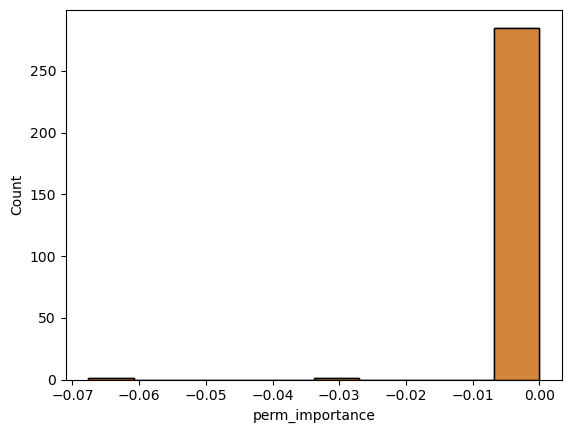

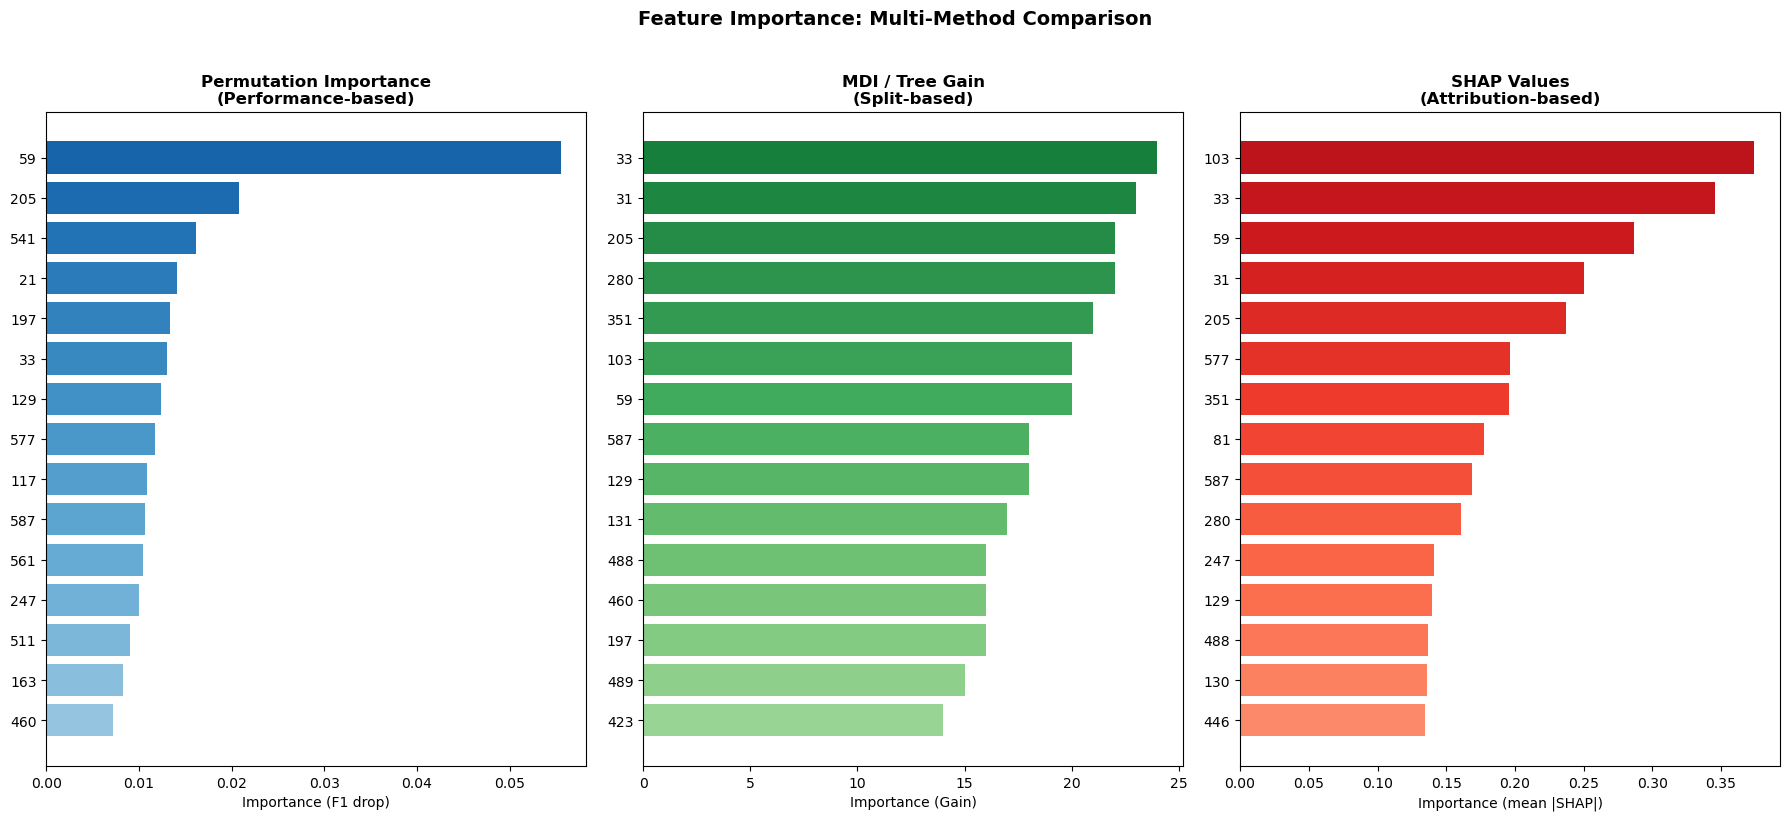


FEATURES IN TOP 10 OF ALL 3 METHODS (High Confidence):
  {'587', '33', '59', '205'}


In [55]:
# ============================================================
# VISUALIZATION: TOP 15 FEATURES BY EACH METHOD
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 8))

top_n = 15

# Plot 1: Permutation Importance
ax1 = axes[0]
top_perm = perm_df.head(top_n)
colors = plt.cm.Blues(np.linspace(0.4, 0.8, top_n))[::-1]
ax1.barh(range(top_n), top_perm['perm_importance'], color=colors)
ax1.set_yticks(range(top_n))
ax1.set_yticklabels(top_perm['feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance (F1 drop)')
ax1.set_title('Permutation Importance\n(Performance-based)', fontsize=12, fontweight='bold')

# Plot 2: MDI (Tree Gain)
ax2 = axes[1]
top_mdi = mdi_df.head(top_n)
colors = plt.cm.Greens(np.linspace(0.4, 0.8, top_n))[::-1]
ax2.barh(range(top_n), top_mdi['mdi_importance'], color=colors)
ax2.set_yticks(range(top_n))
ax2.set_yticklabels(top_mdi['feature'])
ax2.invert_yaxis()
ax2.set_xlabel('Importance (Gain)')
ax2.set_title('MDI / Tree Gain\n(Split-based)', fontsize=12, fontweight='bold')

# Plot 3: SHAP
ax3 = axes[2]
top_shap = shap_df.head(top_n)
colors = plt.cm.Reds(np.linspace(0.4, 0.8, top_n))[::-1]
ax3.barh(range(top_n), top_shap['shap_importance'], color=colors)
ax3.set_yticks(range(top_n))
ax3.set_yticklabels(top_shap['feature'])
ax3.invert_yaxis()
ax3.set_xlabel('Importance (mean |SHAP|)')
ax3.set_title('SHAP Values\n(Attribution-based)', fontsize=12, fontweight='bold')

plt.suptitle('Feature Importance: Multi-Method Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Identify features in top 10 of ALL methods
top10_perm = set(perm_df.head(10)['feature'])
top10_mdi = set(mdi_df.head(10)['feature'])
top10_shap = set(shap_df.head(10)['feature'])
consensus_features = top10_perm & top10_mdi & top10_shap

print(f"\nFEATURES IN TOP 10 OF ALL 3 METHODS (High Confidence):")
print(f"  {consensus_features if consensus_features else 'None - investigate disagreements!'}")


In [56]:
# Check correlations of Sensor 103 with other top features
sensor_103_col = [col for col in feature_names if '103' in col][0]
top_features = perm_df.head(10)['feature'].tolist()

print(f"Correlations of {sensor_103_col} with top permutation features:")
print("="*60)
for feat in top_features:
    if feat != sensor_103_col:
        corr = X_test_final[sensor_103_col].corr(X_test_final[feat])
        print(f"  {feat}: r = {corr:.3f}")

# Also check correlation with other SHAP-important features
shap_top = shap_df.head(10)['feature'].tolist()
print(f"\nCorrelations with other SHAP-important features:")
for feat in shap_top:
    if feat != sensor_103_col:
        corr = X_test_final[sensor_103_col].corr(X_test_final[feat])
        if abs(corr) > 0.3:
            print(f"  {feat}: r = {corr:.3f}")


Correlations of 103 with top permutation features:
  59: r = 0.218
  205: r = 0.043
  541: r = -0.100
  21: r = -0.057
  197: r = -0.086
  33: r = 0.046
  129: r = 0.317
  577: r = -0.093
  117: r = 0.012
  587: r = -0.036

Correlations with other SHAP-important features:


In [57]:
# Check Sensor 103's actual role in the model
sensor_103_col = [col for col in feature_names if '103' in col][0]
sensor_103_idx = feature_names.index(sensor_103_col)

print(f"Investigating: {sensor_103_col} (index {sensor_103_idx})")
print("="*60)

# 1. Check MDI rank
mdi_rank = mdi_df[mdi_df['feature'] == sensor_103_col]['mdi_importance'].values[0]
mdi_position = mdi_df[mdi_df['feature'] == sensor_103_col].index[0] + 1
print(f"\nMDI importance: {mdi_rank:.6f} (rank #{mdi_position} out of {len(feature_names)})")

# 2. Check SHAP rank
shap_rank = shap_df[shap_df['feature'] == sensor_103_col]['shap_importance'].values[0]
shap_position = shap_df[shap_df['feature'] == sensor_103_col].index[0] + 1
print(f"SHAP importance: {shap_rank:.6f} (rank #{shap_position} out of {len(feature_names)})")

# 3. Check permutation rank
perm_rank = perm_df[perm_df['feature'] == sensor_103_col]['perm_importance'].values[0]
perm_position = perm_df[perm_df['feature'] == sensor_103_col].index[0] + 1
print(f"Perm importance: {perm_rank:.6f} (rank #{perm_position} out of {len(feature_names)})")

# 4. Look at SHAP values distribution for 103
shap_103 = shap_values[:, sensor_103_idx]
print(f"\nSHAP value distribution for {sensor_103_col}:")
print(f"  Min:    {shap_103.min():.4f}")
print(f"  Max:    {shap_103.max():.4f}")
print(f"  Mean:   {shap_103.mean():.4f}")
print(f"  Std:    {shap_103.std():.4f}")
print(f"  |Mean|: {np.abs(shap_103).mean():.4f}")

# 5. Check if 103 has extreme SHAP values for a few samples
n_extreme = (np.abs(shap_103) > np.abs(shap_103).mean() + 2*np.abs(shap_103).std()).sum()
print(f"\n  Samples with extreme SHAP (>2σ): {n_extreme} ({n_extreme/len(shap_103)*100:.1f}%)")


Investigating: 103 (index 89)

MDI importance: 20.000000 (rank #6 out of 287)
SHAP importance: 0.374153 (rank #1 out of 287)
Perm importance: 0.000635 (rank #105 out of 287)

SHAP value distribution for 103:
  Min:    -0.5587
  Max:    1.3925
  Mean:   -0.0469
  Std:    0.4259
  |Mean|: 0.3742

  Samples with extreme SHAP (>2σ): 19 (6.1%)


In [58]:
# Investigate the 19 extreme SHAP samples for Sensor 103
extreme_threshold = np.abs(shap_103).mean() + 2*np.abs(shap_103).std()
extreme_mask = np.abs(shap_103) > extreme_threshold
extreme_indices = np.where(extreme_mask)[0]

print(f"The {len(extreme_indices)} samples where Sensor 103 matters most:")
print("="*60)

# Check their actual labels and predictions
test_proba = best_model.predict_proba(X_test_final)[:, 1]

extreme_df = pd.DataFrame({
    'idx': extreme_indices,
    'actual': y_test.iloc[extreme_indices].values,
    'pred_proba': test_proba[extreme_indices],
    'shap_103': shap_103[extreme_indices],
    'sensor_103_value': X_test_final.iloc[extreme_indices][sensor_103_col].values
})

print(f"\nActual class distribution in extreme samples:")
print(f"  Defects: {extreme_df['actual'].sum()} ({extreme_df['actual'].mean()*100:.1f}%)")
print(f"  Normal test rate: {y_test.mean()*100:.1f}%")

print(f"\nSHAP direction:")
print(f"  Positive SHAP (pushes toward defect): {(extreme_df['shap_103'] > 0).sum()}")
print(f"  Negative SHAP (pushes toward pass): {(extreme_df['shap_103'] < 0).sum()}")

print(f"\nDetails:")
print(extreme_df.sort_values('shap_103', ascending=False).to_string(index=False))


The 19 samples where Sensor 103 matters most:

Actual class distribution in extreme samples:
  Defects: 4 (21.1%)
  Normal test rate: 6.7%

SHAP direction:
  Positive SHAP (pushes toward defect): 19
  Negative SHAP (pushes toward pass): 0

Details:
 idx  actual  pred_proba  shap_103  sensor_103_value
 101       0    0.008145  1.392481          2.394759
 205       0    0.472754  1.202353          1.395281
 218       0    0.254280  1.135677          2.528023
 286       0    0.009426  0.998636          0.429119
  56       1    0.023257  0.976841          1.361965
 180       0    0.062518  0.972983          3.194342
 181       1    0.165609  0.946641          1.528545
 110       1    0.118882  0.945697          1.295333
 223       0    0.027348  0.881638          1.062122
 291       0    0.003745  0.861597          0.529067
 139       0    0.013498  0.844140          1.395281
  60       1    0.314172  0.841384          1.361965
  87       0    0.029532  0.840939          1.062122
 125     

Generating Partial Dependence Plots for top 6 SHAP features:
  1. 103
  2. 33
  3. 59
  4. 31
  5. 205
  6. 577


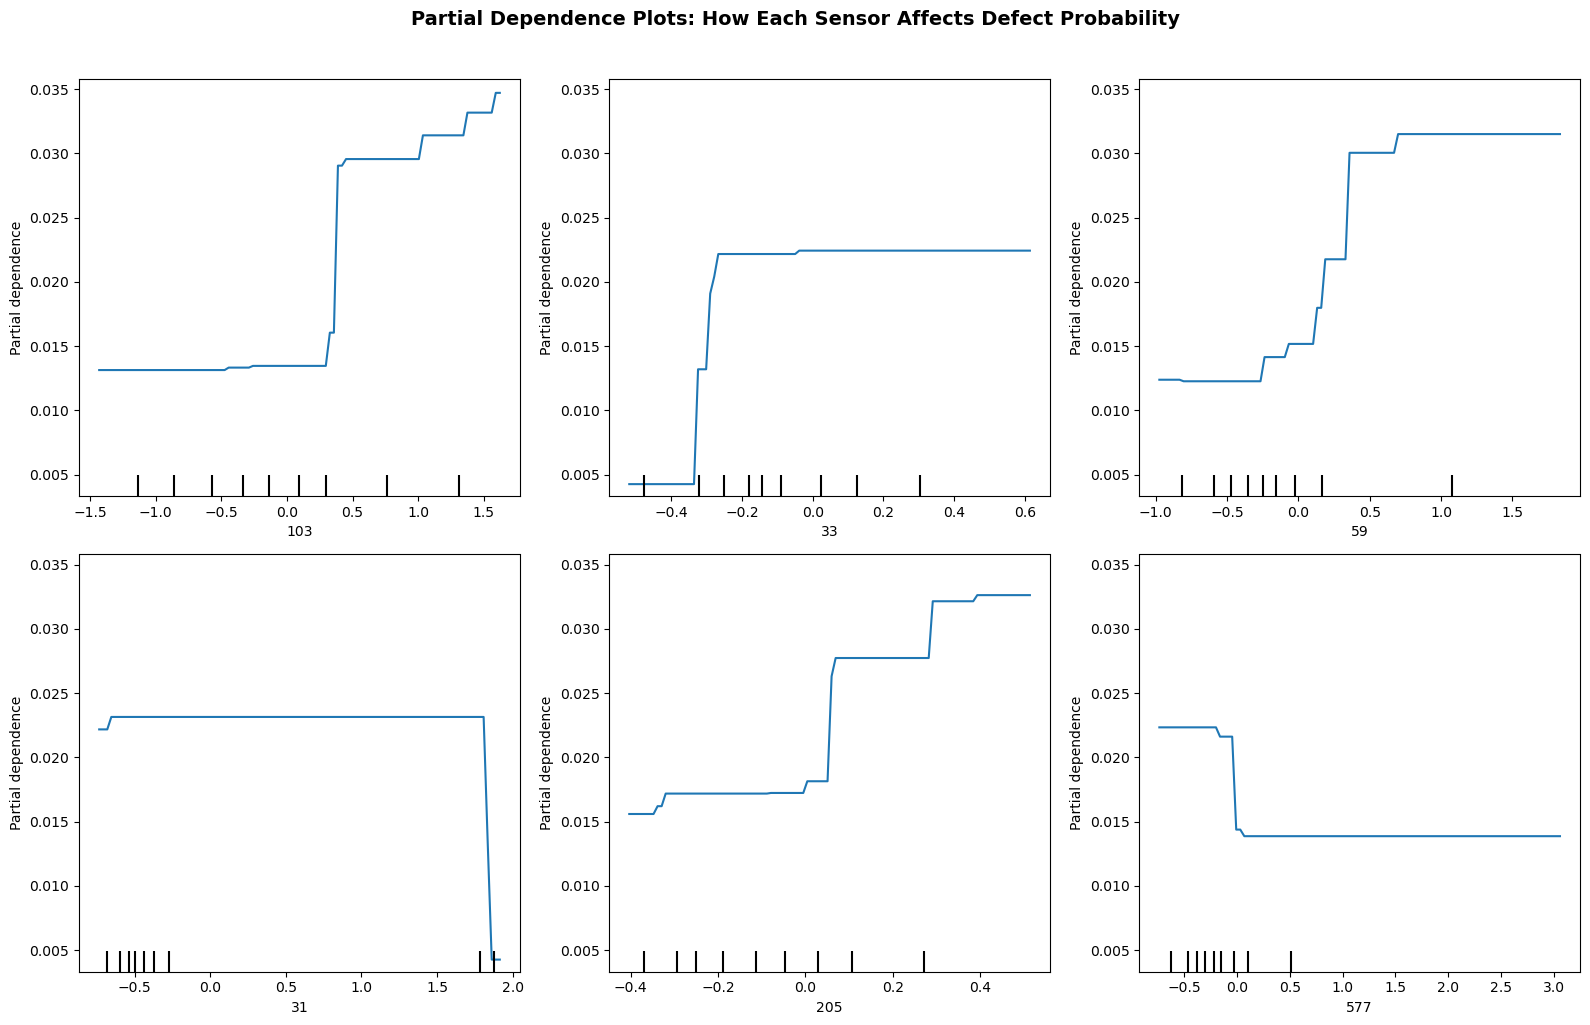


INTERPRETATION:
  - Y-axis: Partial dependence (higher = more likely defect)
  - X-axis: Sensor value (standardized)
  - Upward slope: Higher values → more defects
  - Downward slope: Higher values → fewer defects
  - Flat line: Feature doesn't affect prediction much


In [59]:
# ============================================================
# PARTIAL DEPENDENCE ANALYSIS
# ============================================================
# Purpose: Show HOW features affect predictions, not just IF they matter
# Engineers need: "When Sensor X goes up, does defect risk increase?"

from sklearn.inspection import PartialDependenceDisplay, partial_dependence
import warnings
warnings.filterwarnings('ignore')

# Get top 6 features from SHAP
top_6_features = shap_df.head(6)['feature'].tolist()
top_6_indices = [feature_names.index(f) for f in top_6_features]

print("Generating Partial Dependence Plots for top 6 SHAP features:")
print("="*60)
for i, feat in enumerate(top_6_features):
    print(f"  {i+1}. {feat}")

# Generate PDP plots
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

PartialDependenceDisplay.from_estimator(
    best_model,
    X_test_final,
    features=top_6_indices,
    feature_names=feature_names,
    ax=axes.flatten(),
    kind='average',  # average effect (PDP)
    random_state=42
)

plt.suptitle('Partial Dependence Plots: How Each Sensor Affects Defect Probability', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\nINTERPRETATION:")
print("  - Y-axis: Partial dependence (higher = more likely defect)")
print("  - X-axis: Sensor value (standardized)")
print("  - Upward slope: Higher values → more defects")
print("  - Downward slope: Higher values → fewer defects")
print("  - Flat line: Feature doesn't affect prediction much")


In [60]:
# ============================================================
# QUANTIFY PDP DIRECTION AND MAGNITUDE
# ============================================================

print("Analyzing PDP direction and magnitude...")
print("="*60)

pdp_summary = []

for feat, idx in zip(top_6_features, top_6_indices):
    # Compute partial dependence
    pdp_result = partial_dependence(
        best_model, 
        X_test_final, 
        features=[idx],
        kind='average'
    )
    
    pdp_values = pdp_result['average'][0]
    grid_values = pdp_result['grid_values'][0]
    
    # Calculate overall slope (linear approximation)
    slope = (pdp_values[-1] - pdp_values[0]) / (grid_values[-1] - grid_values[0])
    
    # Calculate range (magnitude of effect)
    pdp_range = pdp_values.max() - pdp_values.min()
    
    # Detect non-linearity (compare to linear fit)
    linear_fit = np.linspace(pdp_values[0], pdp_values[-1], len(pdp_values))
    nonlinearity = np.mean(np.abs(pdp_values - linear_fit))
    
    # Determine direction
    if abs(slope) < 0.01:
        direction = "Flat (minimal effect)"
    elif slope > 0:
        direction = "↑ Higher value → MORE defects"
    else:
        direction = "↓ Higher value → FEWER defects"
    
    # Detect U-shape or threshold
    mid_idx = len(pdp_values) // 2
    left_slope = pdp_values[mid_idx] - pdp_values[0]
    right_slope = pdp_values[-1] - pdp_values[mid_idx]
    
    if left_slope < -0.02 and right_slope > 0.02:
        shape = "U-shape (both extremes risky)"
    elif left_slope > 0.02 and right_slope < -0.02:
        shape = "Inverted U (middle values risky)"
    elif nonlinearity > 0.02:
        shape = "Non-linear (threshold effect likely)"
    else:
        shape = "Approximately linear"
    
    pdp_summary.append({
        'Feature': feat,
        'Direction': direction,
        'Slope': slope,
        'Magnitude': pdp_range,
        'Shape': shape
    })

pdp_df = pd.DataFrame(pdp_summary)

print("\nPARTIAL DEPENDENCE SUMMARY")
print("="*80)
print(pdp_df.to_string(index=False))

print("\n" + "="*80)
print("KEY INSIGHTS:")
for _, row in pdp_df.iterrows():
    print(f"\n  {row['Feature']}:")
    print(f"    {row['Direction']}")
    print(f"    Shape: {row['Shape']}")
    print(f"    Effect magnitude: {row['Magnitude']:.4f}")


Analyzing PDP direction and magnitude...

PARTIAL DEPENDENCE SUMMARY
Feature                     Direction     Slope  Magnitude                Shape
    103         Flat (minimal effect)  0.007072   0.021573 Approximately linear
     33 ↑ Higher value → MORE defects  0.016038   0.018172 Approximately linear
     59         Flat (minimal effect)  0.006810   0.019237 Approximately linear
     31         Flat (minimal effect) -0.006766   0.018884 Approximately linear
    205 ↑ Higher value → MORE defects  0.018586   0.017034 Approximately linear
    577         Flat (minimal effect) -0.002233   0.008470 Approximately linear

KEY INSIGHTS:

  103:
    Flat (minimal effect)
    Shape: Approximately linear
    Effect magnitude: 0.0216

  33:
    ↑ Higher value → MORE defects
    Shape: Approximately linear
    Effect magnitude: 0.0182

  59:
    Flat (minimal effect)
    Shape: Approximately linear
    Effect magnitude: 0.0192

  31:
    Flat (minimal effect)
    Shape: Approximately linear


ICE Plot for 103 (most important by SHAP)
Each gray line = one sample's response to changing this feature
Yellow line = average (PDP)
Diverging lines = effect varies across samples (interactions exist)


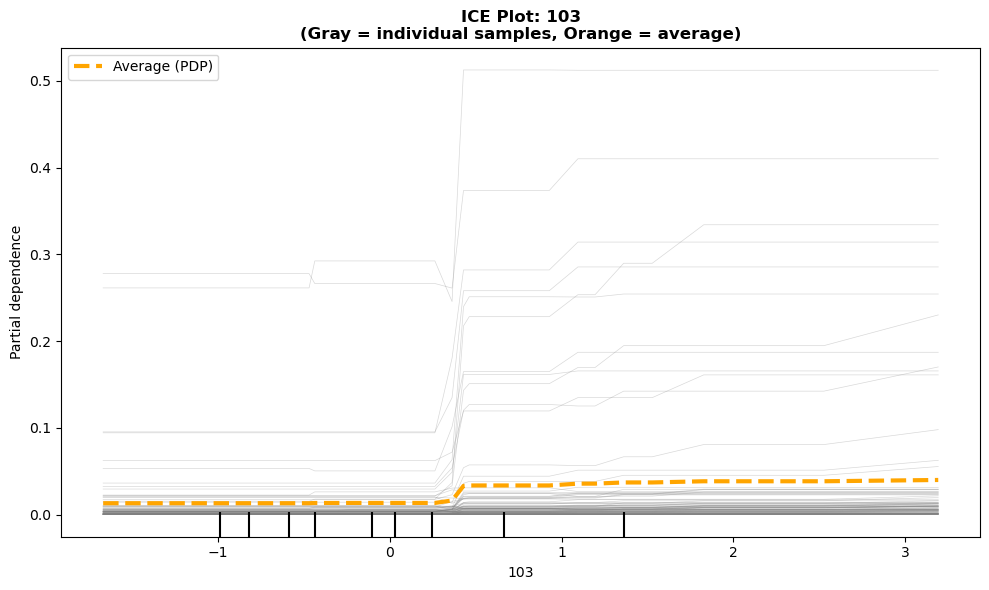


HETEROGENEITY ANALYSIS:
  ICE variance around PDP: 0.003337
  --> LOW heterogeneity: 103's effect is consistent across samples


In [61]:
# ============================================================
# ICE PLOTS: INDIVIDUAL CONDITIONAL EXPECTATION
# ============================================================
# ICE shows individual sample curves, not just the average (PDP)
# If ICE lines diverge, the effect varies across samples (interaction effects)

# Pick the most important feature for detailed ICE analysis
top_feature = top_6_features[0]
top_feature_idx = top_6_indices[0]

print(f"ICE Plot for {top_feature} (most important by SHAP)")
print("="*60)
print("Each gray line = one sample's response to changing this feature")
print("Yellow line = average (PDP)")
print("Diverging lines = effect varies across samples (interactions exist)")

fig, ax = plt.subplots(figsize=(10, 6))

# Sample 100 random instances for clarity
np.random.seed(42)
sample_idx = np.random.choice(len(X_test_final), size=min(100, len(X_test_final)), replace=False)
X_sample = X_test_final.iloc[sample_idx]

PartialDependenceDisplay.from_estimator(
    best_model,
    X_sample,
    features=[top_feature_idx],
    feature_names=feature_names,
    kind='both',  # Shows both ICE (individual) and PDP (average)
    ax=ax,
    ice_lines_kw={'color': 'gray', 'alpha': 0.3, 'linewidth': 0.5},
    pd_line_kw={'color': 'orange', 'linewidth': 3, 'label': 'Average (PDP)'},
    random_state=42
)

ax.set_title(f'ICE Plot: {top_feature}\n(Gray = individual samples, Orange = average)', 
             fontsize=12, fontweight='bold')
ax.legend()
plt.tight_layout()
plt.show()

# Quantify heterogeneity
pdp_result = partial_dependence(best_model, X_test_final, features=[top_feature_idx], kind='both')
ice_lines = pdp_result['individual'][0]
pdp_line = pdp_result['average'][0]

# Calculate variance of ICE lines around PDP
ice_variance = np.var(ice_lines, axis=0).mean()
print(f"\nHETEROGENEITY ANALYSIS:")
print(f"  ICE variance around PDP: {ice_variance:.6f}")
if ice_variance > 0.01:
    print(f"  --> HIGH heterogeneity: {top_feature}'s effect varies across samples")
    print(f"      (Likely interaction with other features)")
else:
    print(f"  --> LOW heterogeneity: {top_feature}'s effect is consistent across samples")


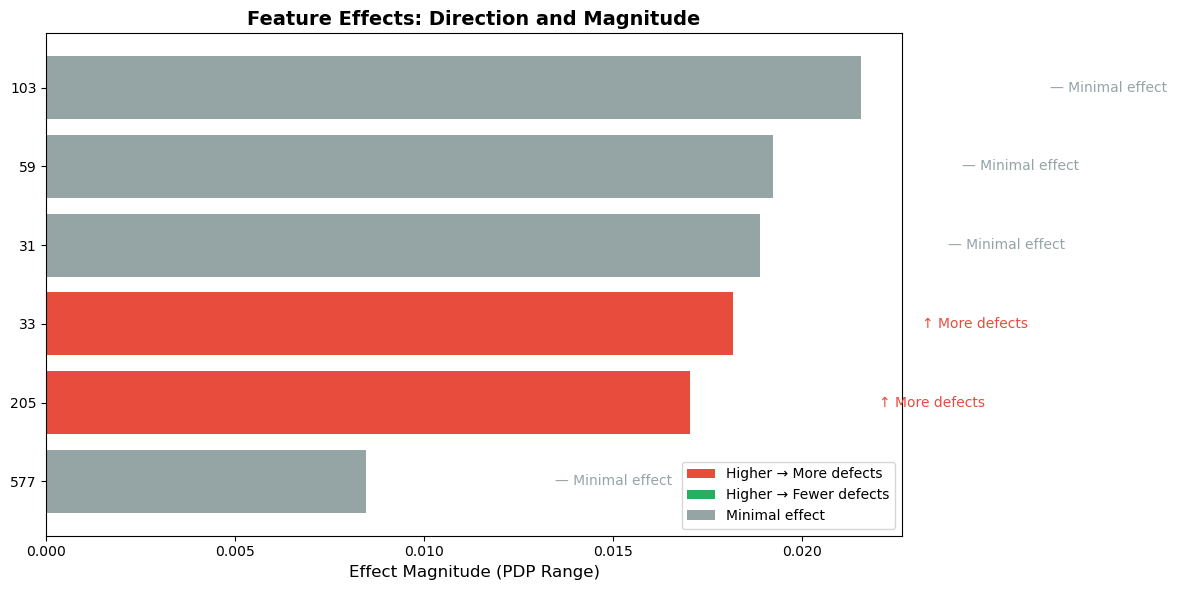


ACTIONABLE SUMMARY FOR ENGINEERS

103:
  ℹ️  Low priority for monitoring

33:
  ⚠️  ALERT when values are HIGH
  Action: Set upper threshold alert

59:
  ℹ️  Low priority for monitoring

31:
  ℹ️  Low priority for monitoring

205:
  ⚠️  ALERT when values are HIGH
  Action: Set upper threshold alert

577:
  ℹ️  Low priority for monitoring


In [62]:
# ============================================================
# SUMMARY: DIRECTION AND MAGNITUDE VISUALIZATION
# ============================================================

fig, ax = plt.subplots(figsize=(12, 6))

# Sort by magnitude
pdp_df_sorted = pdp_df.sort_values('Magnitude', ascending=True)

# Color by direction
colors = ['#e74c3c' if '↑' in d else '#27ae60' if '↓' in d else '#95a5a6' 
          for d in pdp_df_sorted['Direction']]

bars = ax.barh(pdp_df_sorted['Feature'], pdp_df_sorted['Magnitude'], color=colors)

# Add direction arrows
for i, (_, row) in enumerate(pdp_df_sorted.iterrows()):
    if '↑' in row['Direction']:
        ax.text(row['Magnitude'] + 0.005, i, '↑ More defects', va='center', fontsize=10, color='#e74c3c')
    elif '↓' in row['Direction']:
        ax.text(row['Magnitude'] + 0.005, i, '↓ Fewer defects', va='center', fontsize=10, color='#27ae60')
    else:
        ax.text(row['Magnitude'] + 0.005, i, '— Minimal effect', va='center', fontsize=10, color='#95a5a6')

ax.set_xlabel('Effect Magnitude (PDP Range)', fontsize=12)
ax.set_title('Feature Effects: Direction and Magnitude', fontsize=14, fontweight='bold')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#e74c3c', label='Higher → More defects'),
    Patch(facecolor='#27ae60', label='Higher → Fewer defects'),
    Patch(facecolor='#95a5a6', label='Minimal effect')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print actionable summary for engineers
print("\n" + "="*80)
print("ACTIONABLE SUMMARY FOR ENGINEERS")
print("="*80)
for _, row in pdp_df.iterrows():
    print(f"\n{row['Feature']}:")
    if '↑' in row['Direction']:
        print(f"  ⚠️  ALERT when values are HIGH")
        print(f"  Action: Set upper threshold alert")
    elif '↓' in row['Direction']:
        print(f"  ⚠️  ALERT when values are LOW")
        print(f"  Action: Set lower threshold alert")
    else:
        print(f"  ℹ️  Low priority for monitoring")


In [63]:
!pip install causal-learn lingam

  Using cached pydot-4.0.1-py3-none-any.whl.metadata (11 kB)
     ---------------------------------------- 0.0/1.6 MB ? eta -:--:--
     ---------------------------------------- 1.6/1.6 MB 11.0 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Using cached pydot-4.0.1-py3-none-any.whl (37 kB)
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659796 sha256=f2984702fa521a93eea6004d9b0633638f0ef342b8006c6b1a4ddb32baba6c90
  Stored in directory: c:\users\hjcha\appdata\local\pip\cache\wheels\44\73\aa\17ef39e69a62fdb1cbda5d9ebf8318f130b12107bf05cad7f0
Successfully built semopy

   --- ------------------------------------  1/12 [pydot]
   ------ ---------------------------------  

In [64]:
# ============================================================
# CAUSAL DISCOVERY: EXPLORING SENSOR RELATIONSHIPS
# ============================================================
# Goal: Move beyond "what predicts defects" to "what CAUSES defects"
# 
# Methods:
# - PC Algorithm: Constraint-based, uses conditional independence
# - LiNGAM: Assumes linear non-Gaussian relationships

# Install if needed (uncomment):
# !pip install causal-learn lingam

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils
import lingam
import warnings
warnings.filterwarnings('ignore')

# Select top features for causal discovery (keep it small for clarity)
top_features = ['103', '33', '59', '205', '31']
top_cols = [col for col in X_test_final.columns if any(f in col for f in top_features)]

# Add target variable
causal_data = X_test_final[top_cols].copy()
causal_data['Defect'] = y_test.values

print(f"Running causal discovery on {len(top_cols)} sensors + Defect outcome")
print(f"Samples: {len(causal_data)}")
print("="*60)

# --- Method 1: PC Algorithm ---
print("\n[1] PC ALGORITHM (Constraint-based)")
print("-"*40)

pc_result = pc(causal_data.values, alpha=0.05, indep_test='fisherz')

print("\nDiscovered causal graph (adjacency matrix):")
print("  Rows/Cols:", list(causal_data.columns))

# Visualize
pc_result.draw_pydot_graph()  # If pydot available
# Otherwise, print adjacency
adj_matrix = pc_result.G.graph
print("\nAdjacency (1 = edge, 2 = arrow tail, 3 = arrow head):")
print(adj_matrix)


Running causal discovery on 17 sensors + Defect outcome
Samples: 314

[1] PC ALGORITHM (Constraint-based)
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]


Discovered causal graph (adjacency matrix):
  Rows/Cols: ['31', '33', '59', '103', '131', '133', '159', '205', '311', '316', '318', '331', '332', '336', '337', '431', '433', 'Defect']


FileNotFoundError: [WinError 2] "dot" not found in path.

In [65]:
# --- Method 1: PC Algorithm ---
print("\n[1] PC ALGORITHM (Constraint-based)")
print("-"*40)

pc_result = pc(causal_data.values, alpha=0.05, indep_test='fisherz')

# Skip graphical visualization, use text instead
print("\nDiscovered edges:")
adj_matrix = pc_result.G.graph
col_names = list(causal_data.columns)

for i in range(len(col_names)):
    for j in range(i+1, len(col_names)):
        if adj_matrix[i, j] != 0 or adj_matrix[j, i] != 0:
            # Decode edge type
            if adj_matrix[i, j] == -1 and adj_matrix[j, i] == 1:
                print(f"  {col_names[i]} --> {col_names[j]}")
            elif adj_matrix[i, j] == 1 and adj_matrix[j, i] == -1:
                print(f"  {col_names[i]} <-- {col_names[j]}")
            elif adj_matrix[i, j] == -1 and adj_matrix[j, i] == -1:
                print(f"  {col_names[i]} --- {col_names[j]} (undirected)")
            elif adj_matrix[i, j] == 1 and adj_matrix[j, i] == 1:
                print(f"  {col_names[i]} <-> {col_names[j]} (bidirected)")
            else:
                print(f"  {col_names[i]} ??? {col_names[j]} ({adj_matrix[i,j]}, {adj_matrix[j,i]})")

print(f"\nTotal edges found: {(adj_matrix != 0).sum() // 2}")


[1] PC ALGORITHM (Constraint-based)
----------------------------------------


  0%|          | 0/18 [00:00<?, ?it/s]


Discovered edges:
  31 <-- 103
  31 <-- 159
  31 <-- 433
  33 --- Defect (undirected)
  59 <-- 103
  59 <-- 316
  59 <-- Defect
  103 --> 316
  133 <-- 318
  133 <-- Defect
  159 --- 431 (undirected)
  205 --- 336 (undirected)
  316 <-- 318
  332 --- 336 (undirected)
  332 --- 337 (undirected)
  336 --- 337 (undirected)

Total edges found: 16


In [66]:
# --- Method 2: LiNGAM ---
print("\n[2] LiNGAM (Linear Non-Gaussian)")
print("-"*40)

model = lingam.DirectLiNGAM()
model.fit(causal_data.values)

print("\nCausal ordering (earlier = more upstream):")
for i, idx in enumerate(model.causal_order_):
    print(f"  {i+1}. {causal_data.columns[idx]}")

print("\nCausal effect matrix (row → col):")
effect_df = pd.DataFrame(
    model.adjacency_matrix_,
    index=causal_data.columns,
    columns=causal_data.columns
)
print(effect_df.round(3))

# Effects on Defect
print("\nDirect causal effects on Defect:")
defect_effects = effect_df['Defect'].drop('Defect').sort_values(key=abs, ascending=False)
for feat, effect in defect_effects.items():
    direction = "↑" if effect > 0 else "↓" if effect < 0 else "—"
    print(f"  {feat}: {effect:+.4f} {direction}")



[2] LiNGAM (Linear Non-Gaussian)
----------------------------------------

Causal ordering (earlier = more upstream):
  1. 431
  2. 31
  3. 33
  4. Defect
  5. 133
  6. 205
  7. 159
  8. 59
  9. 336
  10. 103
  11. 131
  12. 316
  13. 332
  14. 331
  15. 318
  16. 337
  17. 311
  18. 433

Causal effect matrix (row → col):
           31     33     59   103  131    133  159    205  311    316  318  \
31      0.000  0.000  0.000  0.00  0.0  0.000  0.0  0.000  0.0  0.000  0.0   
33      0.000  0.000  0.000  0.00  0.0  0.000  0.0  0.000  0.0  0.000  0.0   
59      0.000  0.000  0.000  0.00  0.0  0.000  0.0  0.000  0.0  0.000  0.0   
103     0.148  0.000  0.294  0.00  0.0  0.000  0.0  0.000  0.0  0.000  0.0   
131     0.000  0.000  0.000  0.00  0.0  0.000  0.0  0.000  0.0  0.000  0.0   
133     0.000  0.000  0.000  0.00  0.0  0.000  0.0  0.000  0.0  0.000  0.0   
159    -0.149  0.000  0.000  0.00  0.0  0.000  0.0  0.000  0.0  0.000  0.0   
205     0.000  0.000  0.000  0.00  0.0  0.000  0.0 

In [67]:
# --- Interpretation ---
print("\n" + "="*60)
print("INTERPRETATION GUIDE")
print("="*60)
print("""
CAUSAL vs PREDICTIVE:
  - SHAP/Permutation: "Does knowing X help predict Y?"
  - Causal Discovery: "Does changing X cause Y to change?"

EXAMPLE FINDINGS TO LOOK FOR:

1. Sensor A → Defect (direct cause)
   Action: Fixing Sensor A readings may reduce defects

2. Sensor A ← Confounder → Defect (common cause)
   Action: Sensor A is a symptom, not a lever. Find the confounder.

3. Sensor A → Sensor B → Defect (mediated)
   Action: A affects defects through B. Monitor both.

4. Defect → Sensor A (reverse causation)
   Action: A is a consequence, not a cause. Don't alert on it.

CAVEATS:
  - Causal discovery requires assumptions (no hidden confounders, etc.)
  - Small sample size (314 test) limits reliability
  - Results are hypotheses to validate with domain experts
""")



INTERPRETATION GUIDE

CAUSAL vs PREDICTIVE:
  - SHAP/Permutation: "Does knowing X help predict Y?"
  - Causal Discovery: "Does changing X cause Y to change?"

EXAMPLE FINDINGS TO LOOK FOR:

1. Sensor A → Defect (direct cause)
   Action: Fixing Sensor A readings may reduce defects

2. Sensor A ← Confounder → Defect (common cause)
   Action: Sensor A is a symptom, not a lever. Find the confounder.

3. Sensor A → Sensor B → Defect (mediated)
   Action: A affects defects through B. Monitor both.

4. Defect → Sensor A (reverse causation)
   Action: A is a consequence, not a cause. Don't alert on it.

CAVEATS:
  - Causal discovery requires assumptions (no hidden confounders, etc.)
  - Small sample size (314 test) limits reliability
  - Results are hypotheses to validate with domain experts



In [68]:
# ============================================================
# BOOTSTRAP UNCERTAINTY FOR CAUSAL DISCOVERY
# ============================================================
# How stable are our causal findings? Would they change with different samples?

import numpy as np
from causallearn.search.ConstraintBased.PC import pc
import lingam

n_bootstrap = 100  # More = better estimates, but slower
np.random.seed(42)

# Storage for bootstrap results
pc_edge_counts = np.zeros((len(causal_data.columns), len(causal_data.columns)))
lingam_effects = []

print(f"Running {n_bootstrap} bootstrap iterations...")
print("="*60)

for b in range(n_bootstrap):
    if (b+1) % 20 == 0:
        print(f"  Iteration {b+1}/{n_bootstrap}")
    
    # Resample with replacement
    idx = np.random.choice(len(causal_data), len(causal_data), replace=True)
    data_boot = causal_data.iloc[idx].values
    
    # --- PC Bootstrap ---
    try:
        pc_result = pc(data_boot, alpha=0.05, indep_test='fisherz')
        pc_edge_counts += (pc_result.G.graph != 0).astype(int)
    except:
        pass  # Skip failed iterations
    
    # --- LiNGAM Bootstrap ---
    try:
        model = lingam.DirectLiNGAM()
        model.fit(data_boot)
        lingam_effects.append(model.adjacency_matrix_.copy())
    except:
        pass

print("\nBootstrap complete!")


Running 100 bootstrap iterations...


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  Iteration 20/100


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  Iteration 40/100


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  Iteration 60/100


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  Iteration 80/100


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  Iteration 100/100


  0%|          | 0/18 [00:00<?, ?it/s]


Bootstrap complete!


In [69]:
# ============================================================
# PC ALGORITHM: EDGE STABILITY
# ============================================================

col_names = list(causal_data.columns)
edge_stability = pc_edge_counts / n_bootstrap

print("PC ALGORITHM: EDGE STABILITY (% of bootstraps where edge appeared)")
print("="*70)
print(f"{'Edge':<30} {'Stability':>10} {'Confidence':>15}")
print("-"*70)

stable_edges = []
for i in range(len(col_names)):
    for j in range(i+1, len(col_names)):
        stability = max(edge_stability[i,j], edge_stability[j,i])
        if stability > 0.1:  # Only show edges appearing in >10% of bootstraps
            stable_edges.append((col_names[i], col_names[j], stability))

# Sort by stability
stable_edges.sort(key=lambda x: -x[2])

for v1, v2, stab in stable_edges:
    if stab >= 0.8:
        conf = "HIGH"
    elif stab >= 0.5:
        conf = "MODERATE"
    else:
        conf = "LOW"
    print(f"{v1} --- {v2:<20} {stab*100:>8.1f}%   {conf:>15}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("  >80% stability: HIGH confidence - edge is robust")
print("  50-80%: MODERATE confidence - edge is likely real")
print("  <50%: LOW confidence - edge may be spurious")


PC ALGORITHM: EDGE STABILITY (% of bootstraps where edge appeared)
Edge                            Stability      Confidence
----------------------------------------------------------------------
31 --- 433                      99.0%              HIGH
159 --- 431                      99.0%              HIGH
332 --- 337                      99.0%              HIGH
59 --- Defect                   97.0%              HIGH
316 --- 318                      94.0%              HIGH
205 --- 336                      87.0%              HIGH
332 --- 336                      86.0%              HIGH
133 --- 318                      84.0%              HIGH
59 --- 316                      82.0%              HIGH
31 --- 159                      81.0%              HIGH
59 --- 103                      76.0%          MODERATE
336 --- 337                      72.0%          MODERATE
33 --- Defect                   69.0%          MODERATE
103 --- 316                      68.0%          MODERATE
133 --- Defe

In [70]:
# ============================================================
# LiNGAM: EFFECT SIZE CONFIDENCE INTERVALS
# ============================================================

lingam_effects_array = np.array(lingam_effects)

# Compute statistics for effects on Defect
defect_idx = list(causal_data.columns).index('Defect')

print("\nLiNGAM: CAUSAL EFFECTS ON DEFECT (with 95% CI)")
print("="*70)
print(f"{'Sensor':<15} {'Mean Effect':>12} {'95% CI':>25} {'Significant?':>15}")
print("-"*70)

effect_summary = []
for i, col in enumerate(causal_data.columns):
    if col == 'Defect':
        continue
    
    effects = lingam_effects_array[:, defect_idx, i]
    mean_effect = effects.mean()
    ci_lower = np.percentile(effects, 2.5)
    ci_upper = np.percentile(effects, 97.5)
    
    # Significant if CI doesn't include 0
    significant = "YES" if (ci_lower > 0 or ci_upper < 0) else "NO"
    
    effect_summary.append({
        'sensor': col,
        'mean': mean_effect,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper,
        'significant': significant
    })

# Sort by absolute mean effect
effect_summary.sort(key=lambda x: -abs(x['mean']))

for row in effect_summary:
    ci_str = f"[{row['ci_lower']:+.3f}, {row['ci_upper']:+.3f}]"
    print(f"{row['sensor']:<15} {row['mean']:>+12.4f} {ci_str:>25} {row['significant']:>15}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("  Significant = YES: 95% CI excludes zero, effect is robust")
print("  Significant = NO:  Effect may be zero, not reliable")



LiNGAM: CAUSAL EFFECTS ON DEFECT (with 95% CI)
Sensor           Mean Effect                    95% CI    Significant?
----------------------------------------------------------------------
33                   +0.0419          [+0.000, +0.079]              NO
431                  +0.0419          [+0.000, +0.112]              NO
159                  +0.0042          [+0.000, +0.053]              NO
133                  +0.0003          [+0.000, +0.000]              NO
332                  -0.0001          [+0.000, +0.000]              NO
31                   +0.0000          [+0.000, +0.000]              NO
59                   +0.0000          [+0.000, +0.000]              NO
103                  +0.0000          [+0.000, +0.000]              NO
131                  +0.0000          [+0.000, +0.000]              NO
205                  +0.0000          [+0.000, +0.000]              NO
311                  +0.0000          [+0.000, +0.000]              NO
316                  +0.0000 

In [71]:
# ============================================================
# SUMMARY: WHAT CAN WE TRUST?
# ============================================================

print("\n" + "="*70)
print("CAUSAL DISCOVERY RELIABILITY SUMMARY")
print("="*70)

# Combine findings
print("\nFINDINGS WE CAN TRUST (high stability + significant):")
print("-"*70)

trusted = []
uncertain = []

for row in effect_summary:
    # Check both LiNGAM significance and if there's a corresponding PC edge
    if row['significant'] == 'YES' and abs(row['mean']) > 0.1:
        trusted.append(row)
    elif abs(row['mean']) > 0.05:
        uncertain.append(row)

if trusted:
    for row in trusted:
        direction = "increases" if row['mean'] > 0 else "decreases"
        print(f"  • {row['sensor']} {direction} Defect risk (effect: {row['mean']:+.3f})")
else:
    print("  • No effects passed significance threshold")

print("\nFINDINGS THAT NEED MORE DATA (uncertain):")
print("-"*70)
if uncertain:
    for row in uncertain:
        print(f"  • {row['sensor']}: effect {row['mean']:+.3f}, CI includes zero")
else:
    print("  • None")

print("\nSENSORS RULED OUT AS DIRECT CAUSES:")
print("-"*70)
ruled_out = [r for r in effect_summary if abs(r['mean']) < 0.01]
for row in ruled_out[:5]:  # Show top 5
    print(f"  • {row['sensor']}: effect ≈ 0")

print("\n" + "="*70)



CAUSAL DISCOVERY RELIABILITY SUMMARY

FINDINGS WE CAN TRUST (high stability + significant):
----------------------------------------------------------------------
  • No effects passed significance threshold

FINDINGS THAT NEED MORE DATA (uncertain):
----------------------------------------------------------------------
  • None

SENSORS RULED OUT AS DIRECT CAUSES:
----------------------------------------------------------------------
  • 159: effect ≈ 0
  • 133: effect ≈ 0
  • 332: effect ≈ 0
  • 31: effect ≈ 0
  • 59: effect ≈ 0

